##### Steps to detect duration and frequency of ball bouncing from wav file
1. Import necessary libraries
2. Open audio File
3. Detect periods of activity
4. For Each period, find the frequency of the ball
5. Output: 
    1. Plot a graph identifying periods of activity 
    2. Plot a sample period sinsoidal wave over activity
    3. Output excel file with columns: start period, end period, duration, frequency, number of bounces

1. Import necessary libraries

In [206]:
from pydub import AudioSegment
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pydub.utils import mediainfo
import numpy, scipy.optimize
import pandas as pd
import os
from pydub.playback import play
from scipy.signal import find_peaks

2. Open audio File

In [207]:
MINIMUM_BOUNCES_TO_ADD_TO_RESULTS=5
SHOW_FIGURES=True
SHOW_DEBUG_MESSAGES=True
INITIAL_WINDOW_SIZE=1000
PERCENTILE_LEVEL = 80
FIG_SIZE = [18, 8]
SOUND_FILES_FOLDER = './sound_files'
ORIGINALS_SUB_FOLDER = 'originals'
FILE_NAME_ONLY_DICT = {'original_work_file': 'sound_of_ball_original.wav',
                       'file_with_breathing': 'pep4_2nd_original.mp3', 'fifth_file': 'AUD-20231221-WA0007_5th.m4a'}
FILE_NAME_ONLY=FILE_NAME_ONLY_DICT['fifth_file']
FILE_NAME = os.path.join(SOUND_FILES_FOLDER, ORIGINALS_SUB_FOLDER, FILE_NAME_ONLY)
info = mediainfo(FILE_NAME)
original_sample_rate=int(info['sample_rate'])
sound = AudioSegment.from_file(FILE_NAME)
# some files are stereo, then select the channel with higher power
if info['channels'] == '2':  # stereo
    sound_split = sound.split_to_mono()
    if sound_split[0].dBFS > sound_split[1].dBFS:
        sound = sound_split[0]
    else:
        sound = sound_split[1]

samples = sound.get_array_of_samples()
samples_list=samples.tolist()

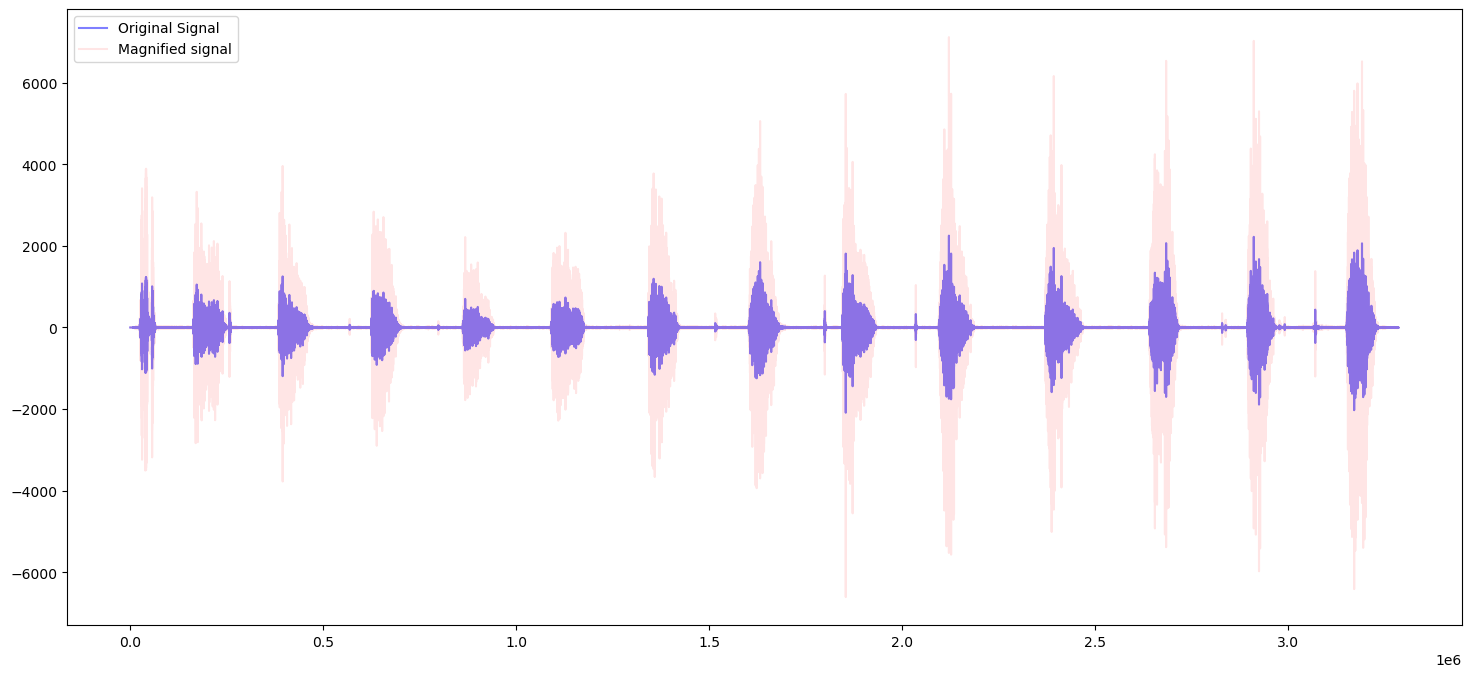

In [208]:
sound_louder = sound+10
if SHOW_FIGURES:
    plt.figure(figsize=FIG_SIZE)
    _=plt.plot(samples_list, alpha=.5, color='blue', label='Original Signal')
    _=plt.plot(sound_louder.get_array_of_samples().tolist(), alpha=0.1, color='red', label='Magnified signal')
    plt.legend(loc='best')

3. Detect periods of activity

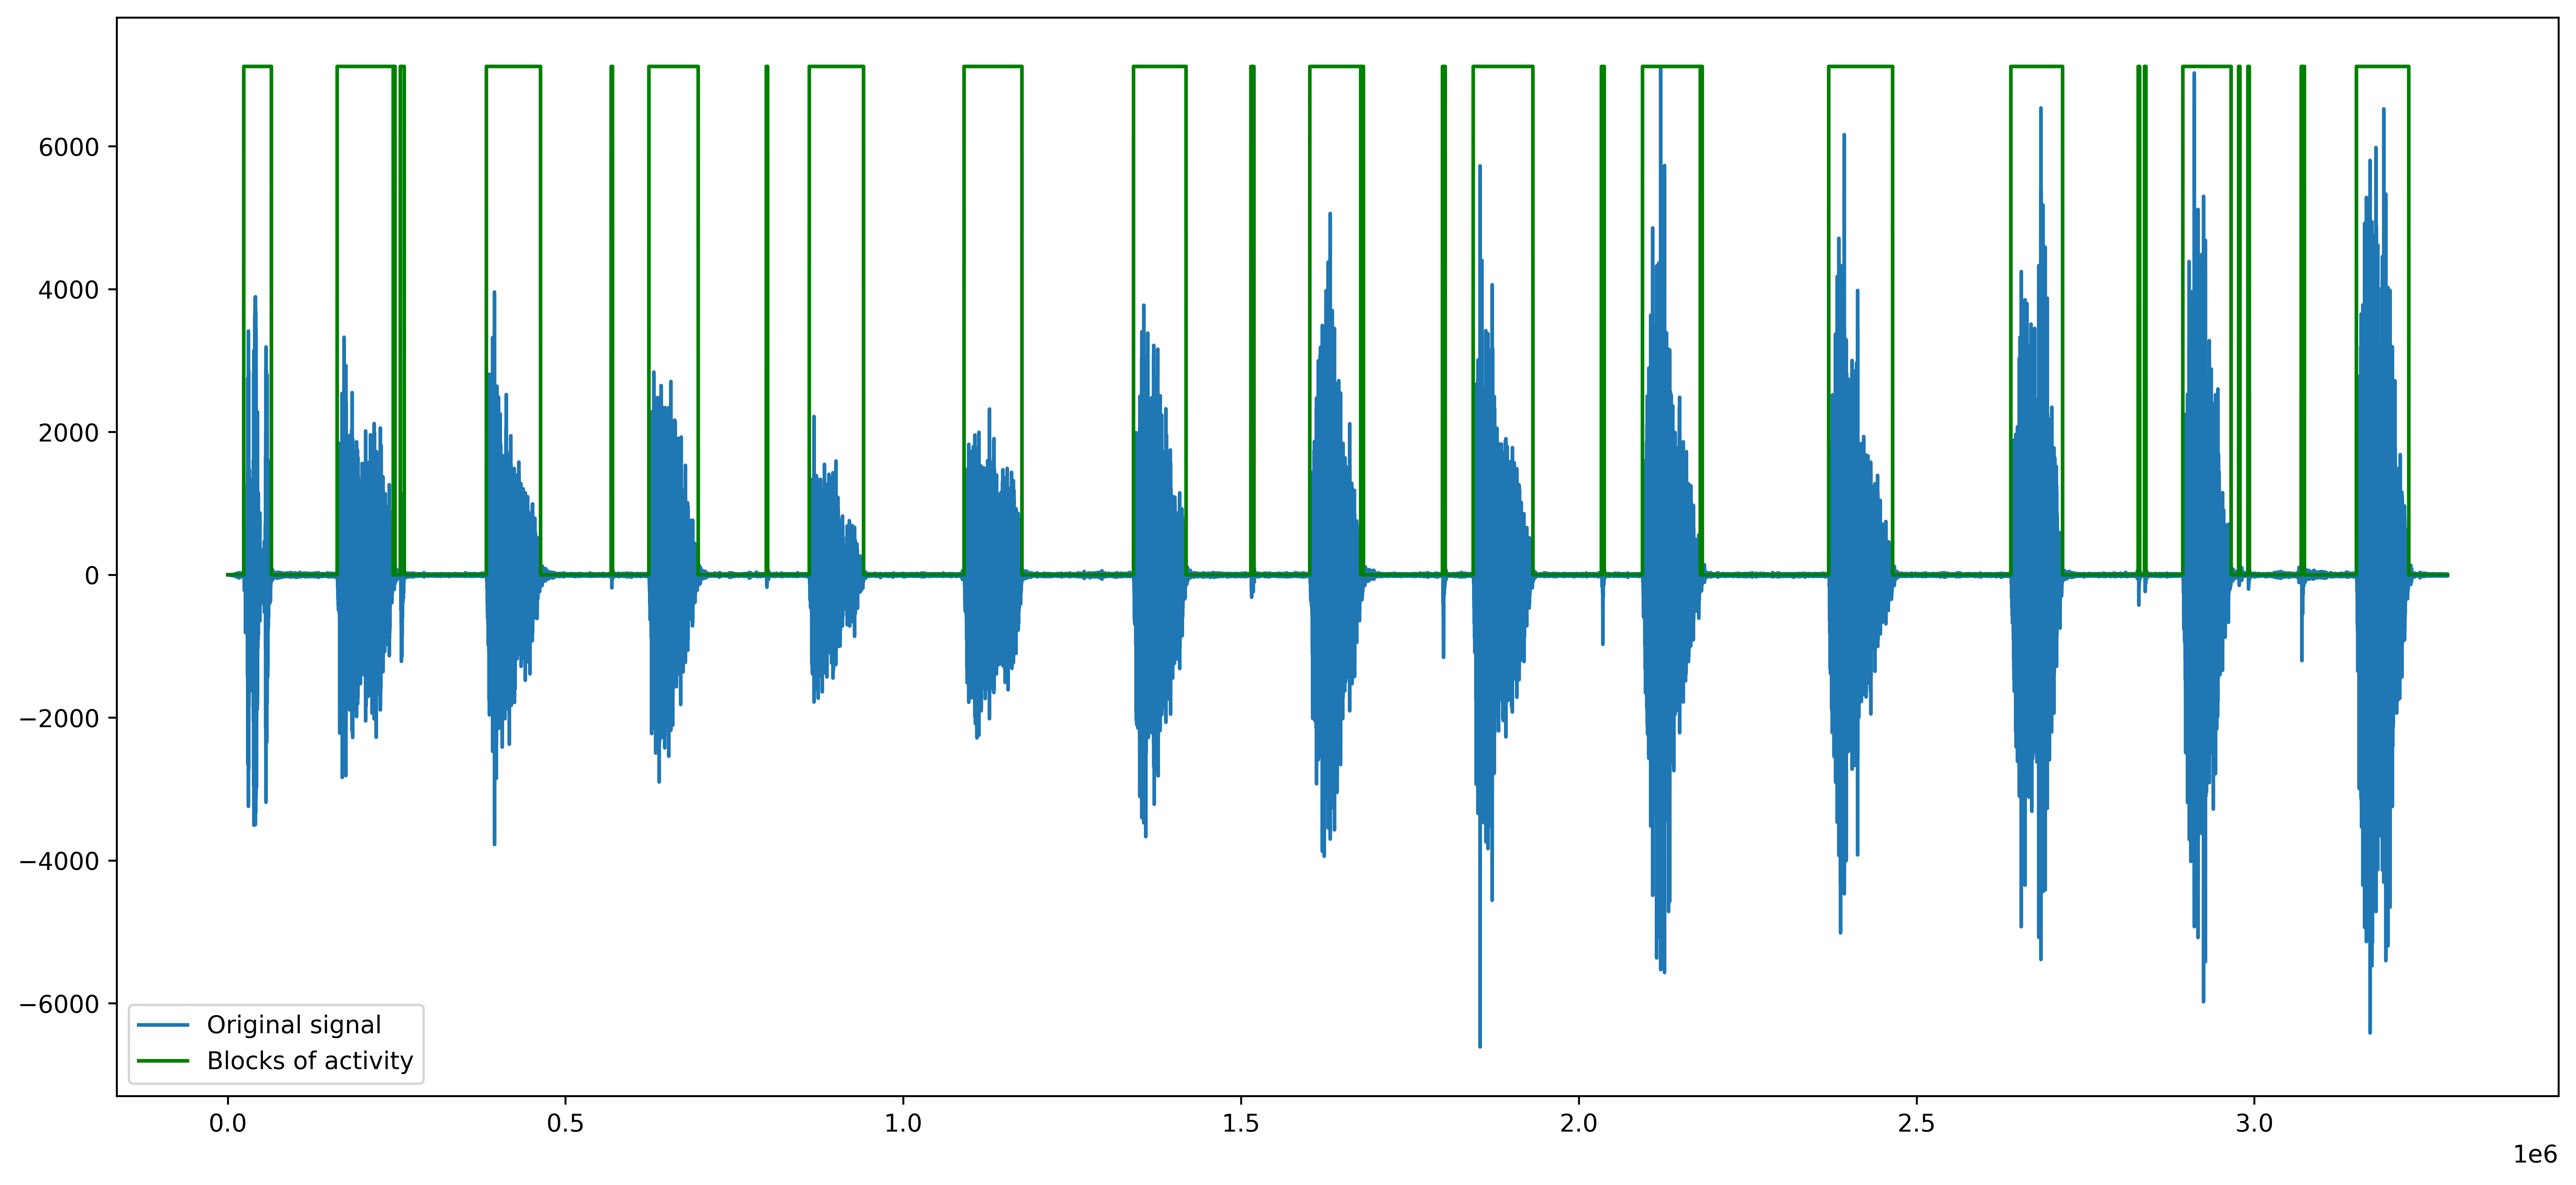

In [209]:
# 80 th percentile and window size of 1000 are good estimates
samples_list=sound_louder.get_array_of_samples().tolist()
window_size=INITIAL_WINDOW_SIZE
abs_samples_list = [abs(ele) for ele in samples_list]
abs_samples_list_pd=pd.Series(abs_samples_list)
req_percentile=np.percentile(abs_samples_list,PERCENTILE_LEVEL)
max_val=max(abs_samples_list)
# [f(x) if condition else g(x) for x in sequence]
signal_on=[max_val if x >req_percentile else 0 for x in abs_samples_list]
block_signal_on=signal_on.copy()
for i in range(window_size, len(samples_list)-window_size):
    if max_val in signal_on[i-window_size:i+window_size]:
        block_signal_on[i]=max_val
if SHOW_FIGURES:
    plt.figure(figsize=FIG_SIZE,dpi=600)
    plt.plot(samples_list, label='Original signal')
    plt.plot(block_signal_on,'g', label='Blocks of activity')
    plt.legend(loc='best')
    plt.show()

Identify periods of activity start and end

In [210]:
signal_on_periods=[]
period_start=-1
period_end=-1
for i in range(len(block_signal_on)):
    if block_signal_on[i]!=0:
        if period_start==-1:
            period_start=i
    else:
        if period_start!=-1 and period_end==-1:
            period_end = i
            signal_on_periods.append(tuple([period_start, period_end]))
            period_start=period_end=-1

Method 2: detecting and counting energy

In [211]:
def sinfunc(t, A, w, p, c):
    return A * numpy.sin(w*t + p) + c
def fit_sin(tt, yy):
    '''Fit sin to the input time sequence, and return fitting parameters "amp", "omega", "phase", "offset", "freq", "period" and "fitfunc"'''
    tt = numpy.array(tt)
    yy = numpy.array(yy)
    ff = numpy.fft.fftfreq(len(tt), (tt[1]-tt[0]))   # assume uniform spacing
    Fyy = abs(numpy.fft.fft(yy))
    guess_freq = abs(ff[numpy.argmax(Fyy[1:])+1])   # excluding the zero frequency "peak", which is related to offset
    guess_amp = numpy.std(yy) * 2.**0.5
    guess_offset = numpy.mean(yy)
    guess = numpy.array([guess_amp, 2.*numpy.pi*guess_freq, 0., guess_offset])

    popt, pcov = scipy.optimize.curve_fit(sinfunc, tt, yy, p0=guess)
    A, w, p, c = popt
    f = w/(2.*numpy.pi)
    fitfunc = lambda t: A * numpy.sin(w*t + p) + c
    return {"amp": A, "omega": w, "phase": p, "offset": c, "freq": f, "period": 1./f, "fitfunc": fitfunc, "maxcov": numpy.max(pcov), "rawres": (guess,popt,pcov)}

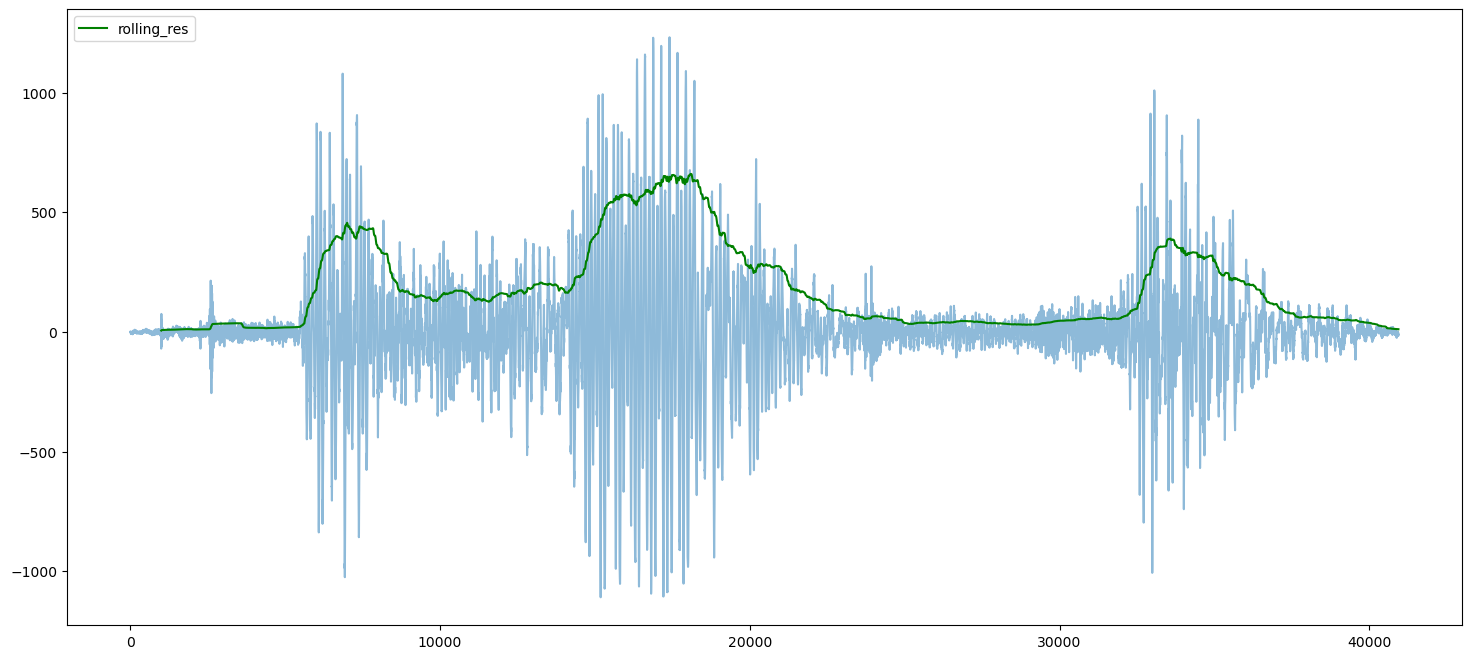

Amplitude=0.23798357603740536, Angular freq.=0.0007016748322279018, phase=0.27177673353793363, offset=-0.003053994132572652, Max. Cov.=0.00026709786725490227


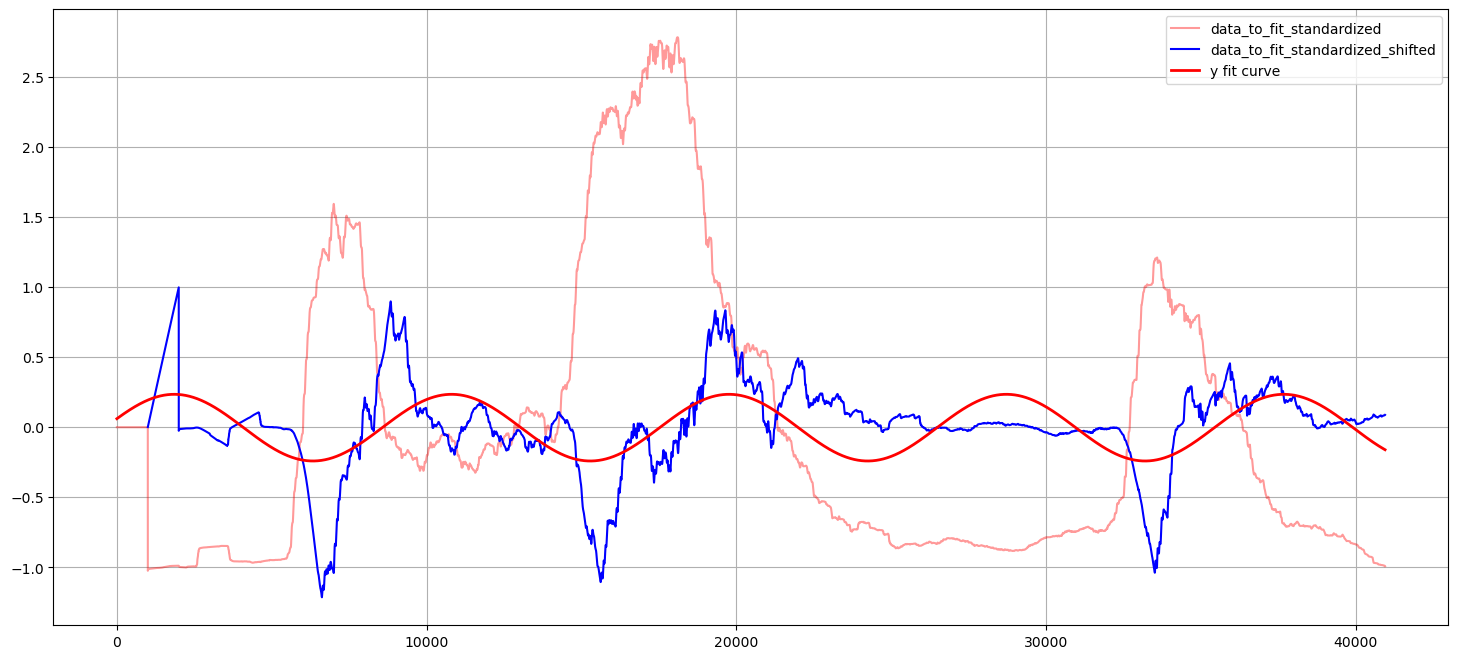

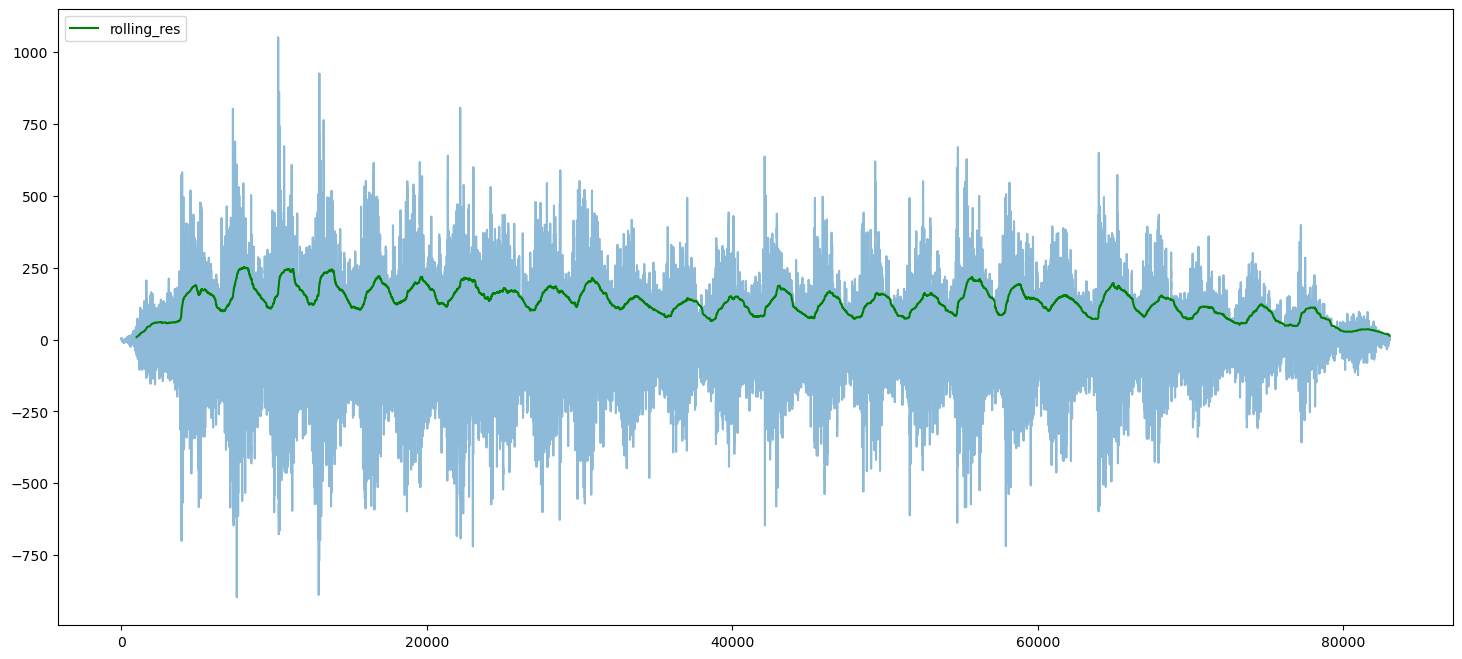

Amplitude=-0.40220492292483134, Angular freq.=0.001966372103145907, phase=-1.072146946840113, offset=0.012715103868664777, Max. Cov.=0.00016579427586598585


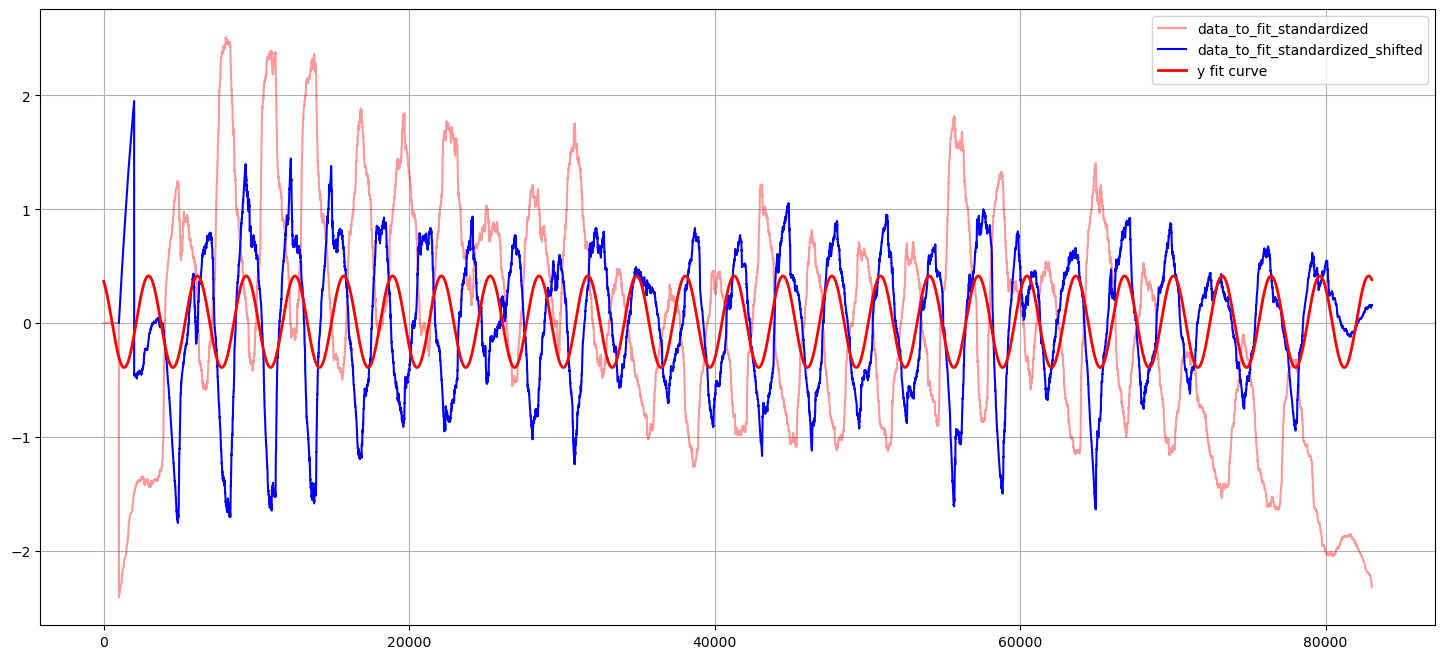

The bouncing frequency: 0.00031295784017367737	Period bounce count: 25	Period duration: 1.7298125


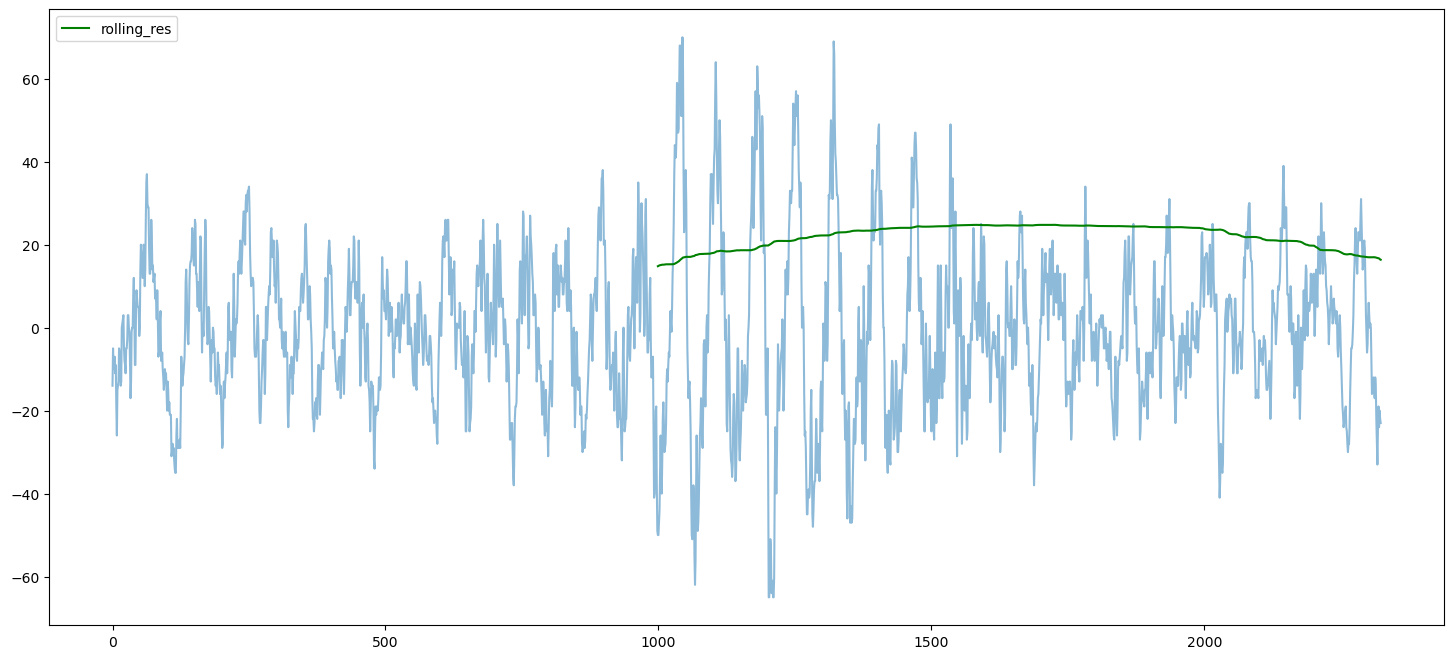

Amplitude=0.7378026723414749, Angular freq.=0.003859267243765863, phase=2.7213619367966237, offset=-0.21191511397271234, Max. Cov.=0.002081216925189065


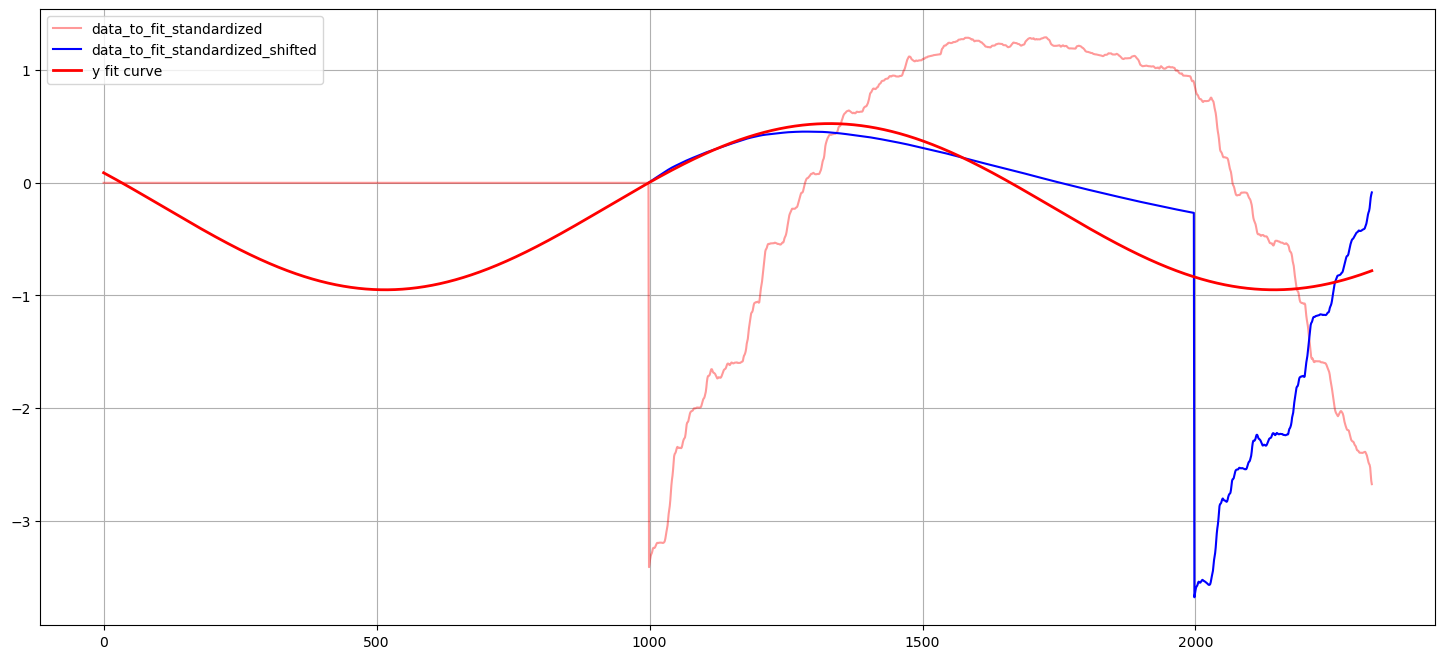

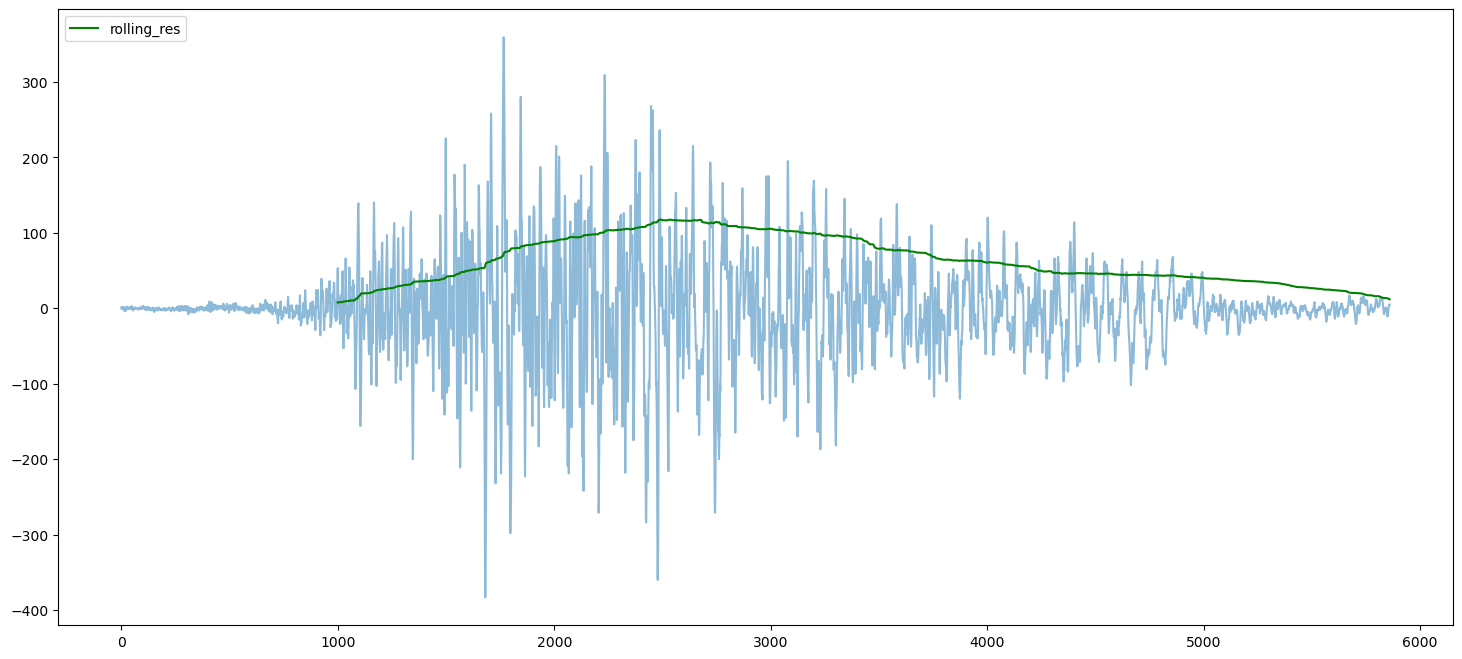

Amplitude=0.7392473375227592, Angular freq.=0.001742187612399773, phase=0.014719239951594023, offset=-0.022086099919859145, Max. Cov.=0.0005633255326288294


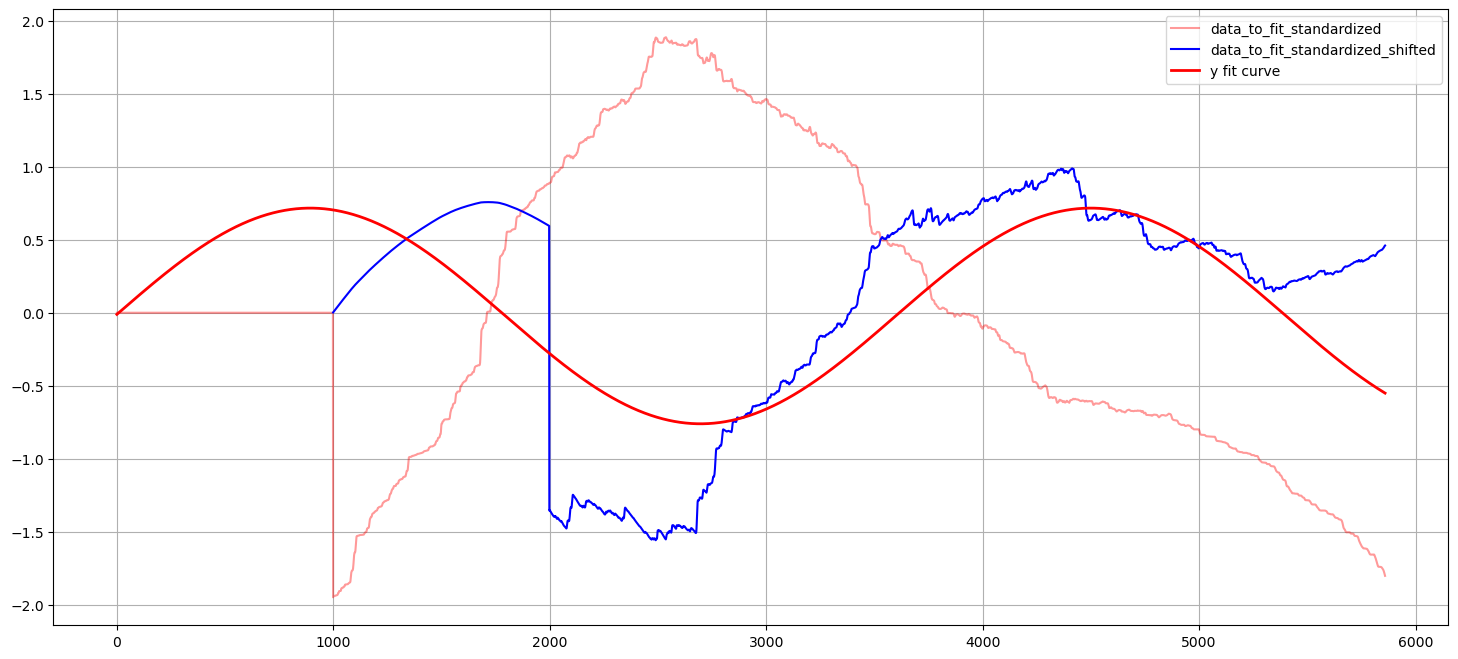

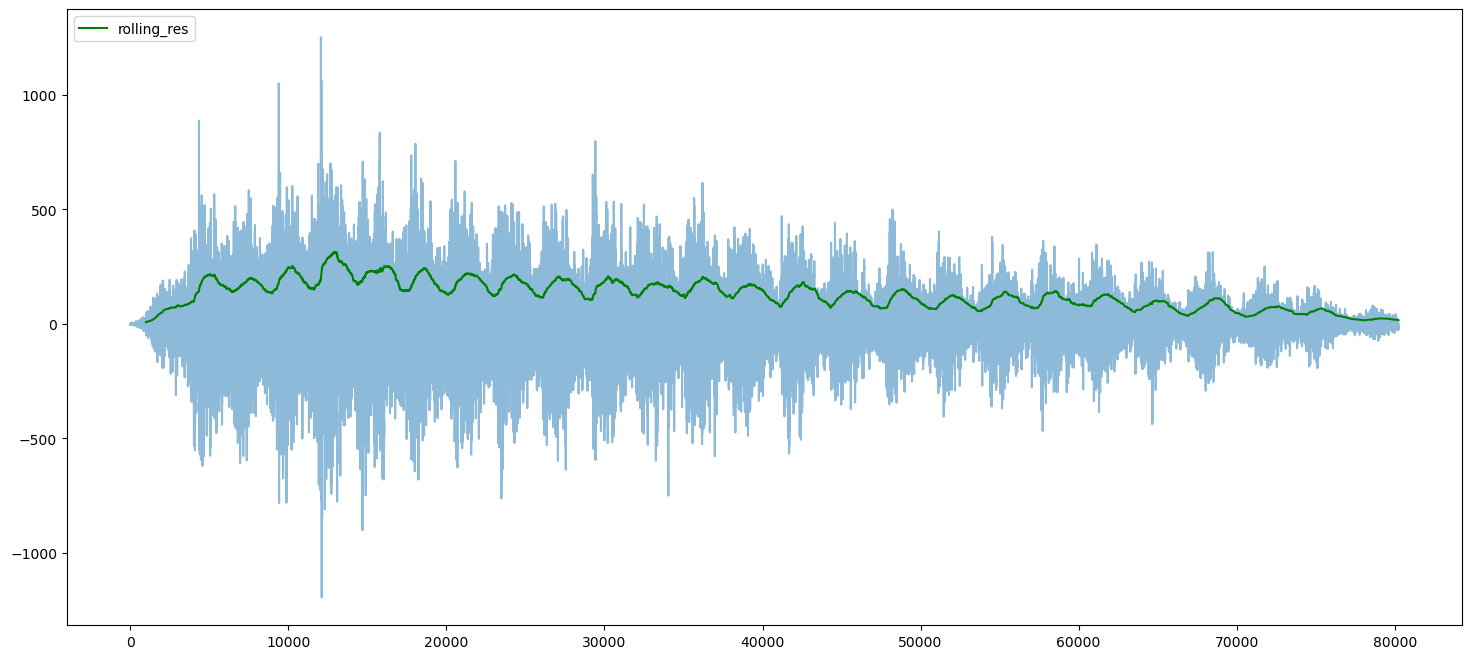

Amplitude=-0.24778432745124293, Angular freq.=0.002088959538580635, phase=0.3732548579643655, offset=0.012341401268191705, Max. Cov.=0.0002578323511659197


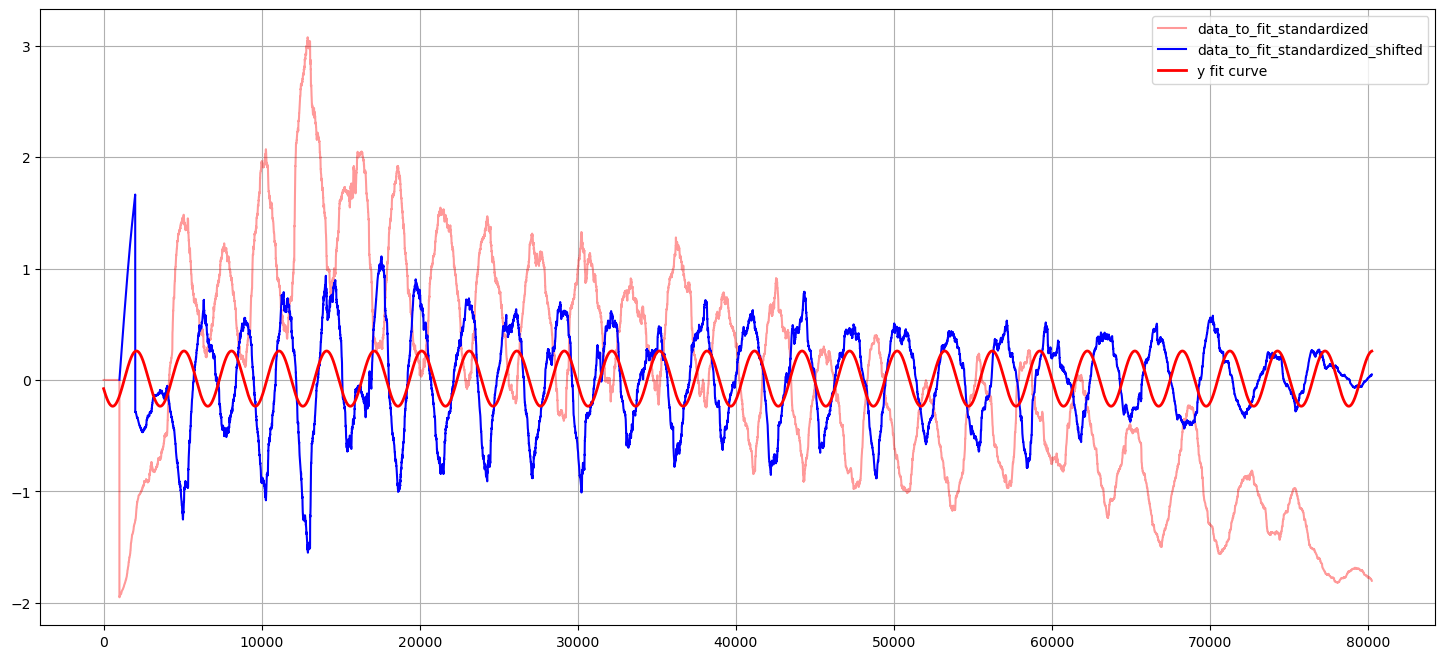

The bouncing frequency: 0.0003324682364840729	Period bounce count: 26	Period duration: 1.6715208333333333


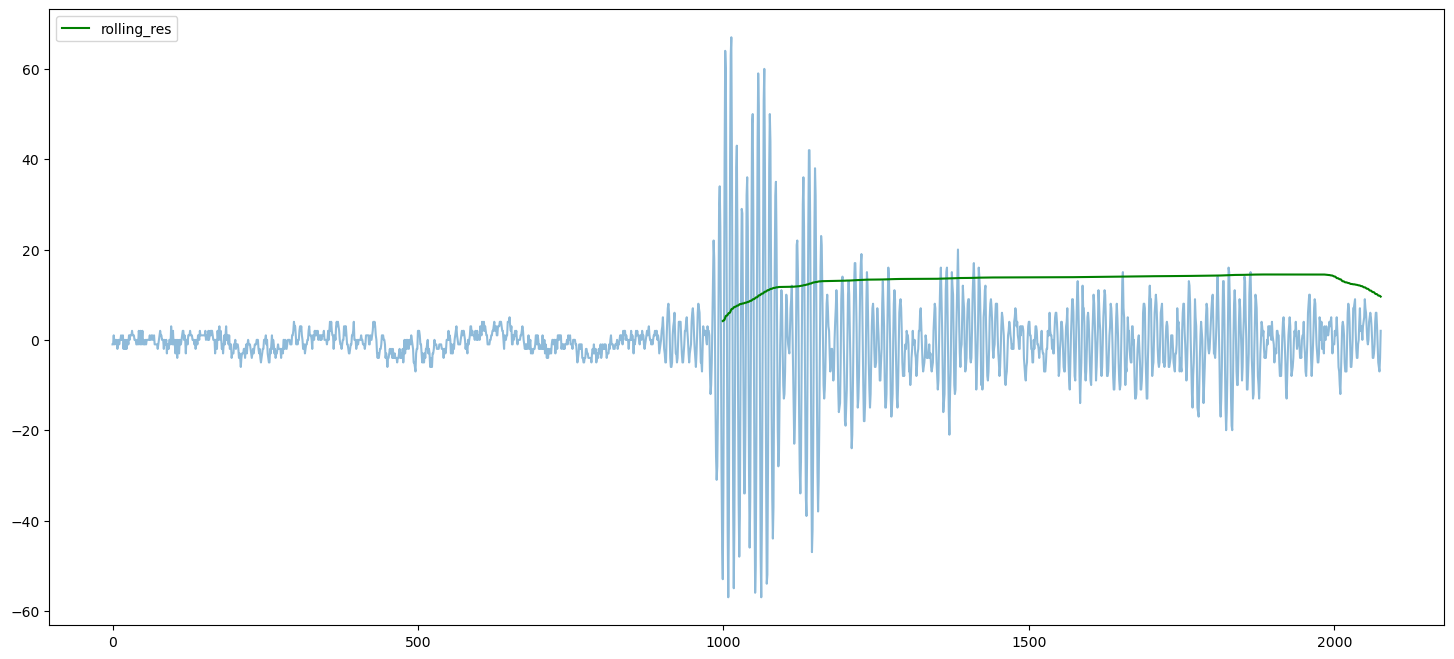

Amplitude=0.5385404860100834, Angular freq.=0.0040045061754784275, phase=2.5909880729972543, offset=-0.03700620784495899, Max. Cov.=0.007448884319262898


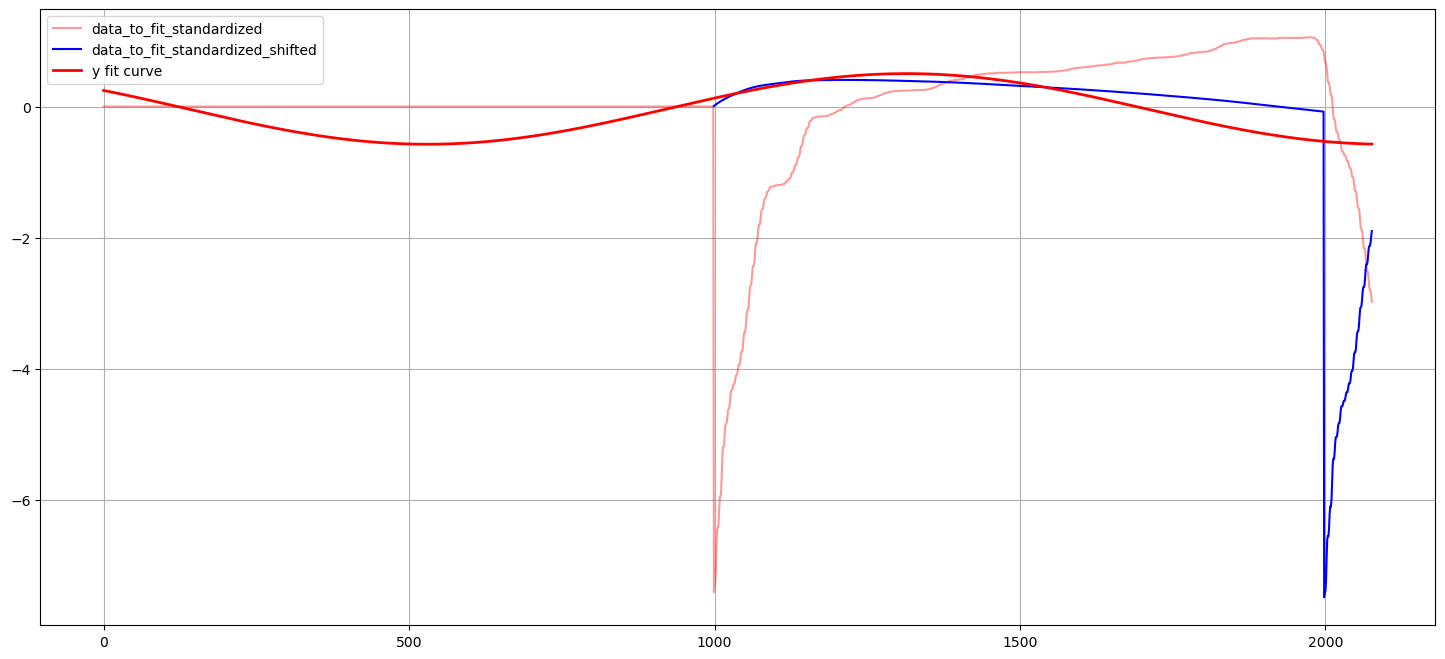

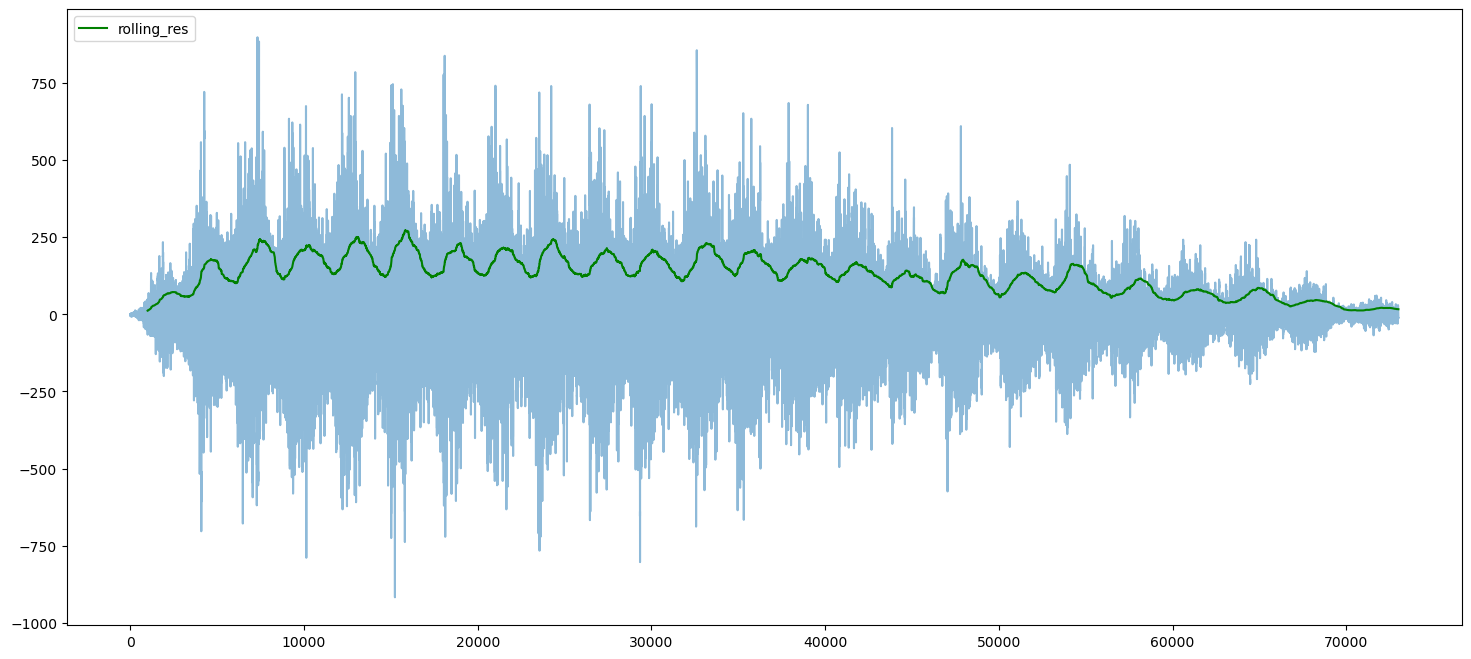

Amplitude=-0.3798919987735382, Angular freq.=0.00216633270531209, phase=-1.481175747963805, offset=0.010231123062969813, Max. Cov.=0.00011986301490421184


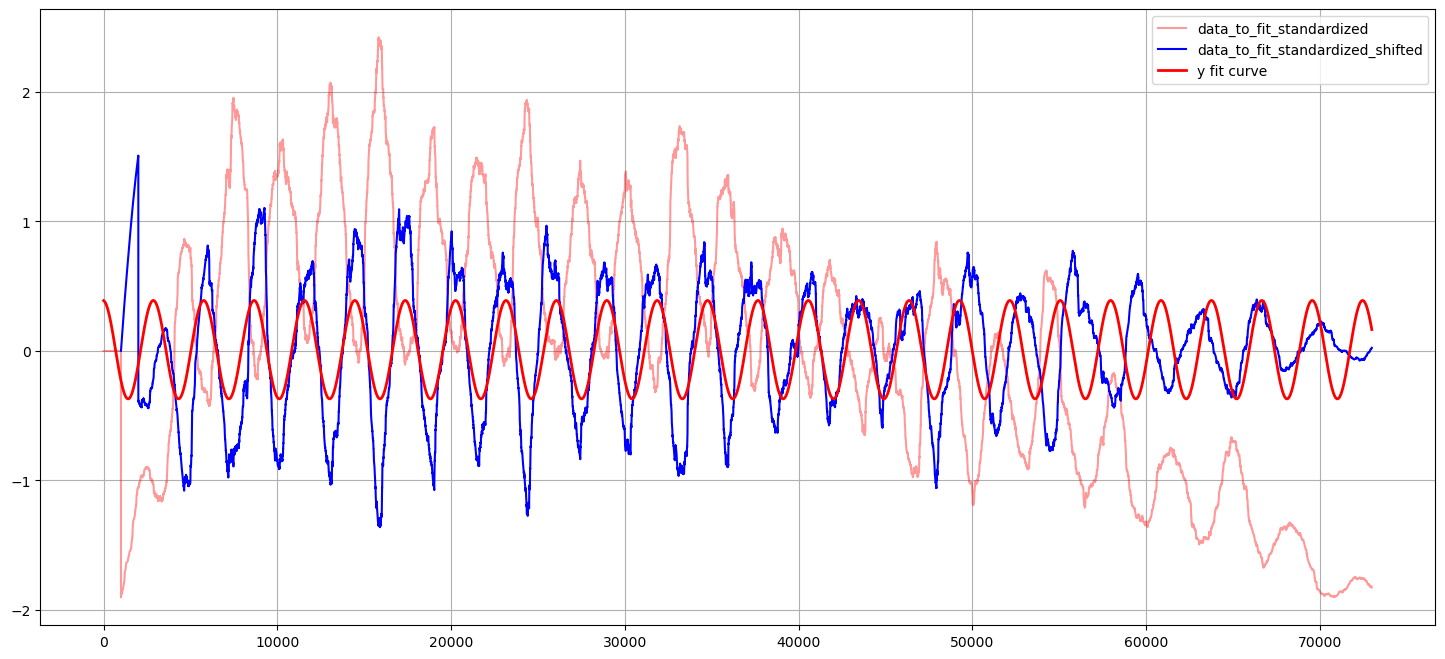

The bouncing frequency: 0.00034478255843205734	Period bounce count: 25	Period duration: 1.5208333333333333


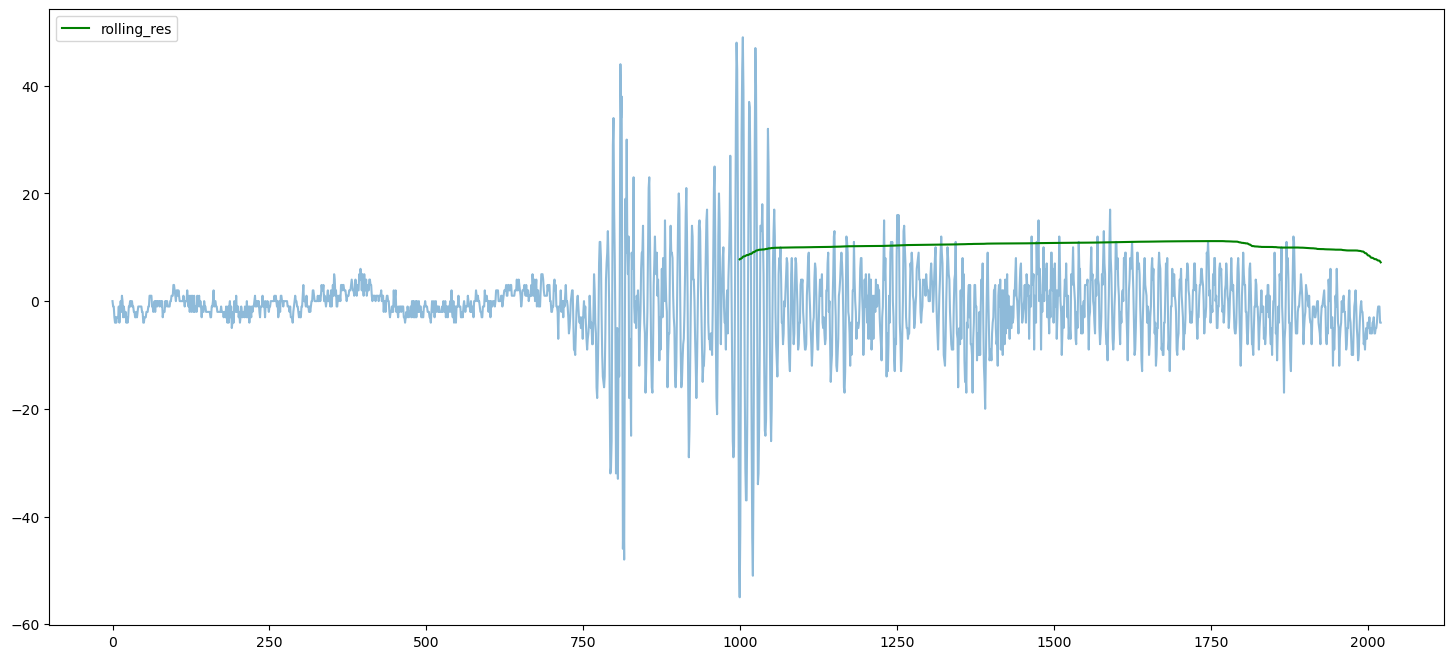

Amplitude=0.2538489083978472, Angular freq.=0.0041765518656375344, phase=2.6490075423803545, offset=-0.05089123917475857, Max. Cov.=0.008652174195711668


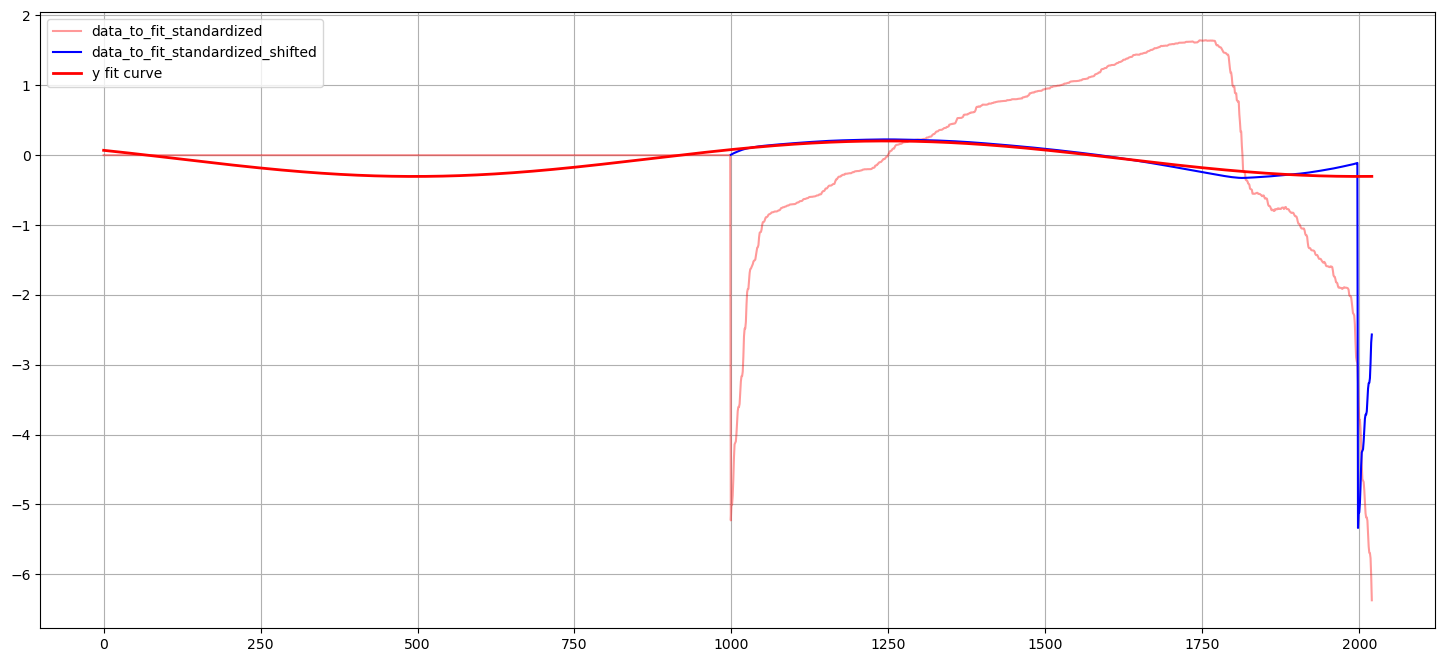

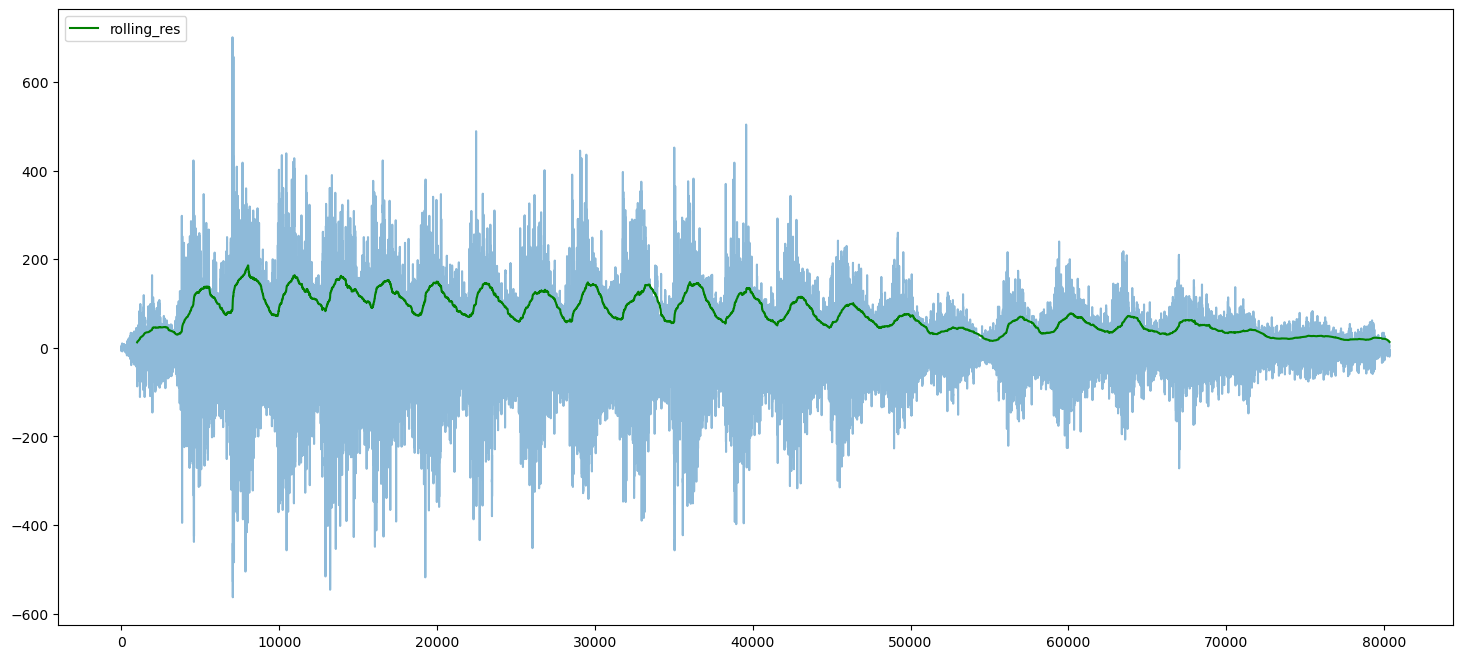

Amplitude=-0.31936167224712536, Angular freq.=0.0019845358111706037, phase=-1.1781101487947776, offset=0.008489559014773426, Max. Cov.=0.00016335996904067381


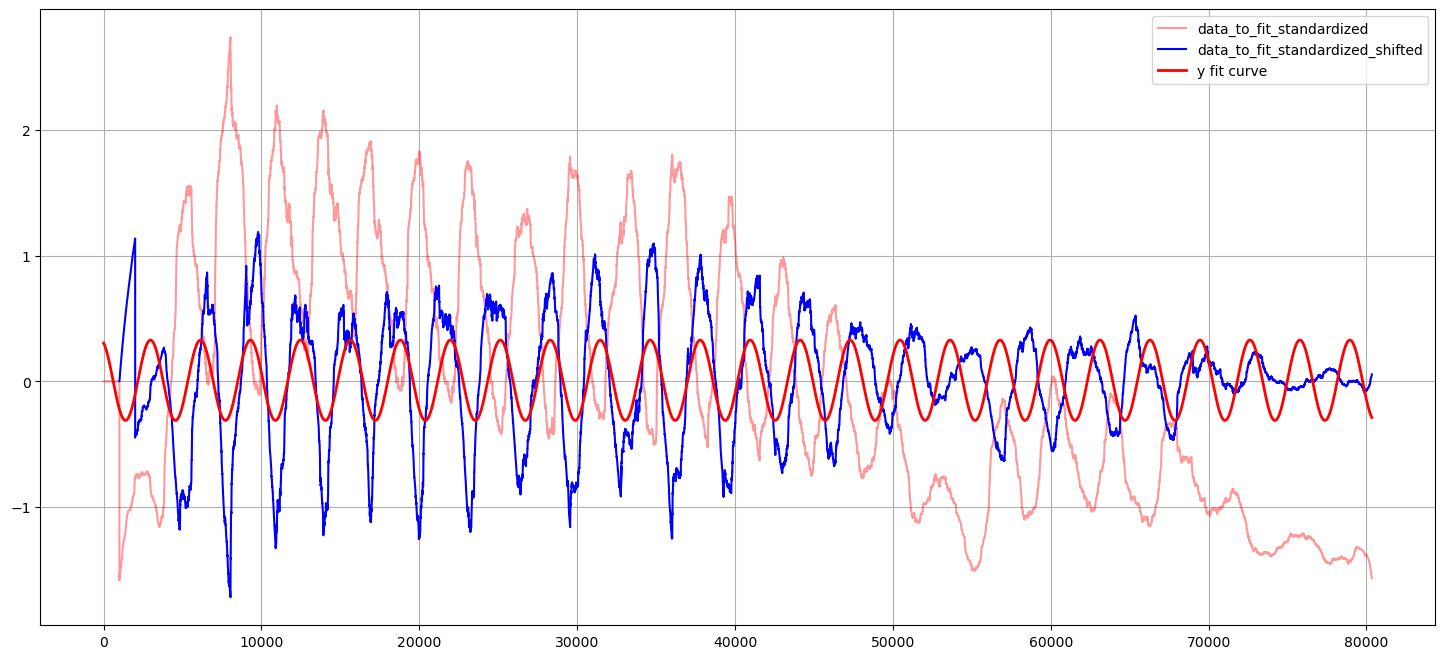

The bouncing frequency: 0.0003158486840906858	Period bounce count: 25	Period duration: 1.6738125


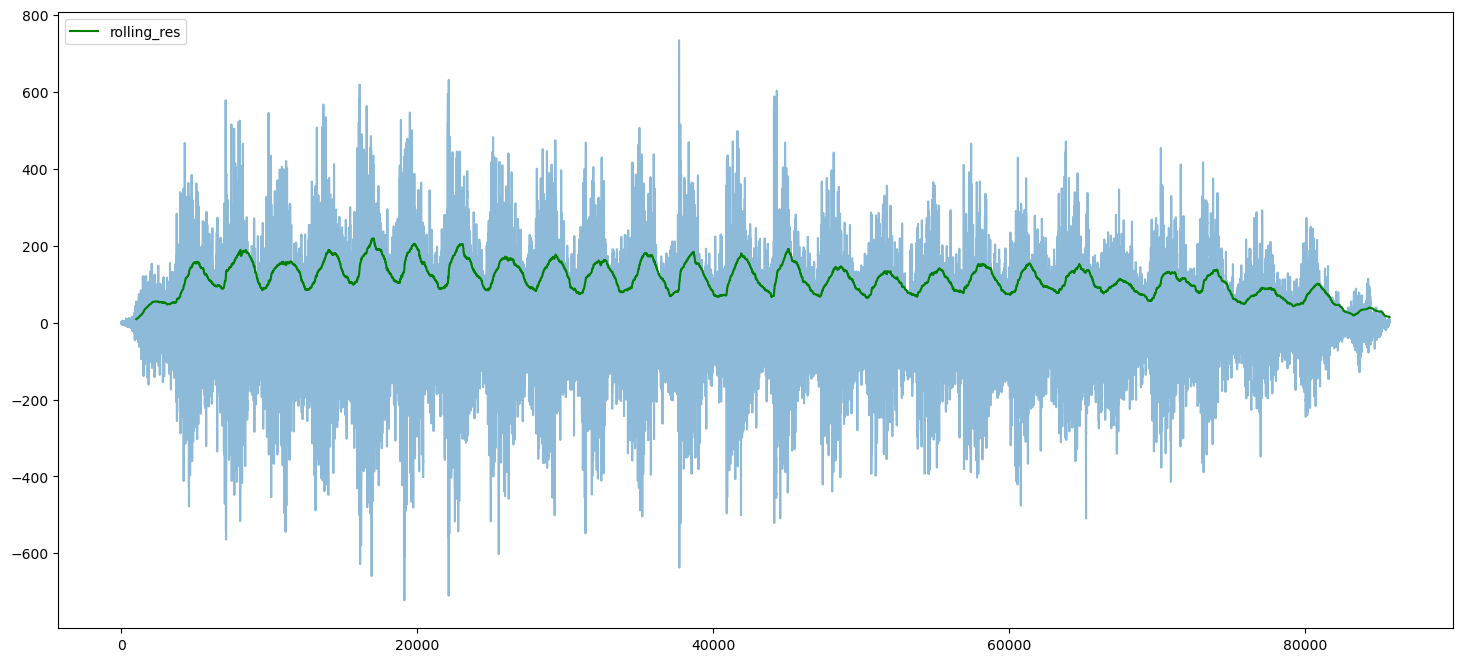

Amplitude=-0.5880479644401293, Angular freq.=0.0019804519502880755, phase=-0.2300532155156585, offset=0.012040788871520488, Max. Cov.=6.332617556319547e-05


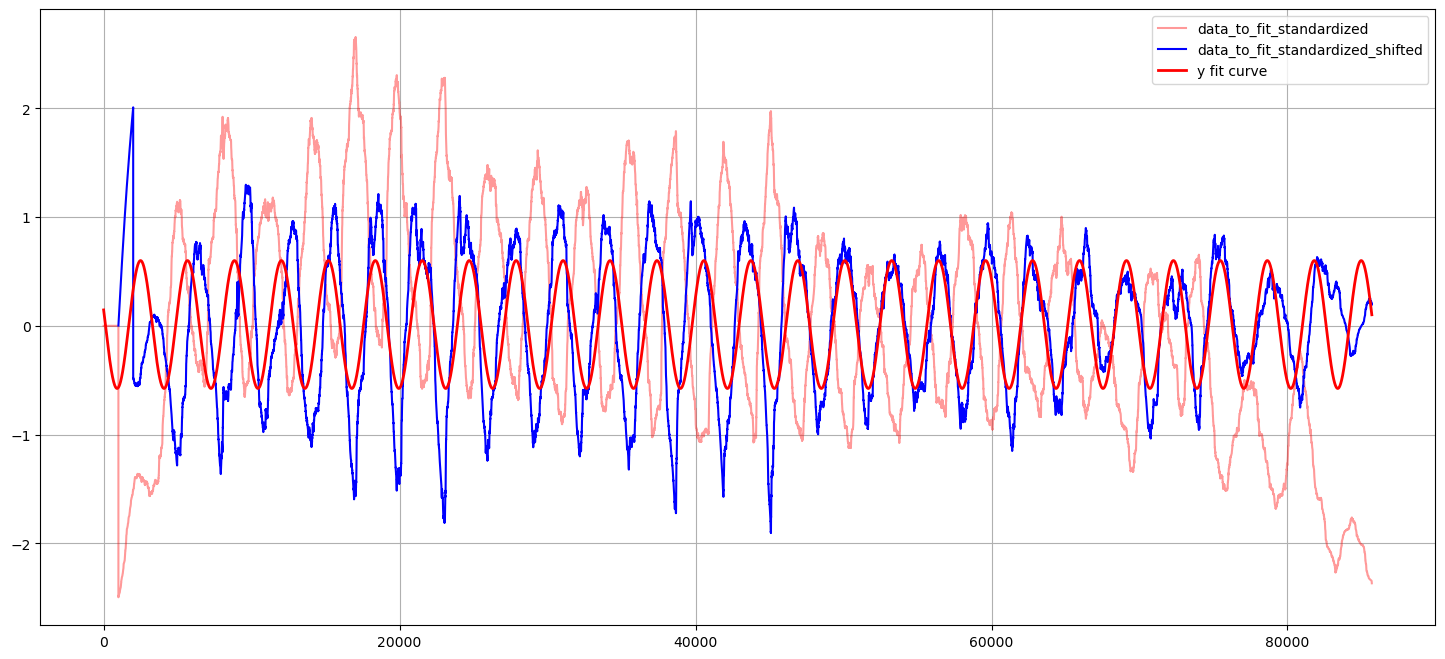

The bouncing frequency: 0.0003151987174443318	Period bounce count: 27	Period duration: 1.7854166666666667


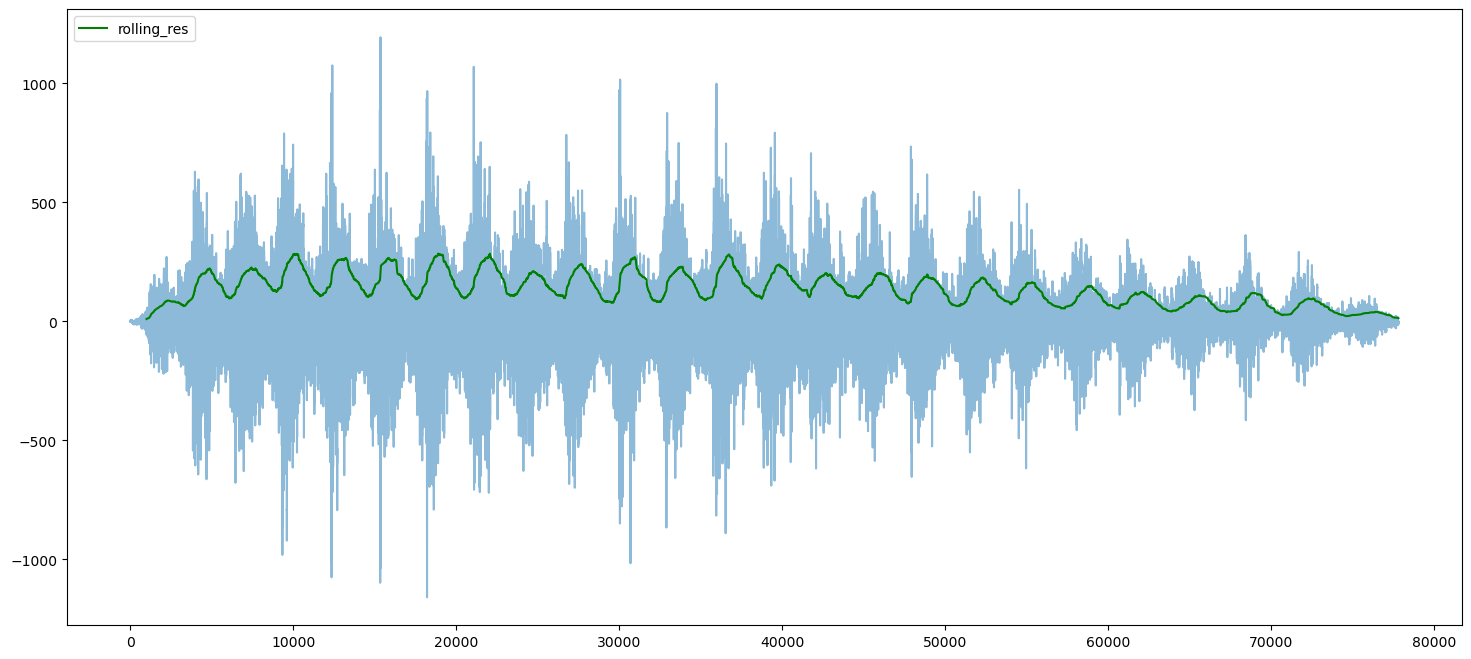

Amplitude=-0.5407158762609742, Angular freq.=0.002108758930173994, phase=-0.7278056142746603, offset=0.00983687773793873, Max. Cov.=8.540944068058912e-05


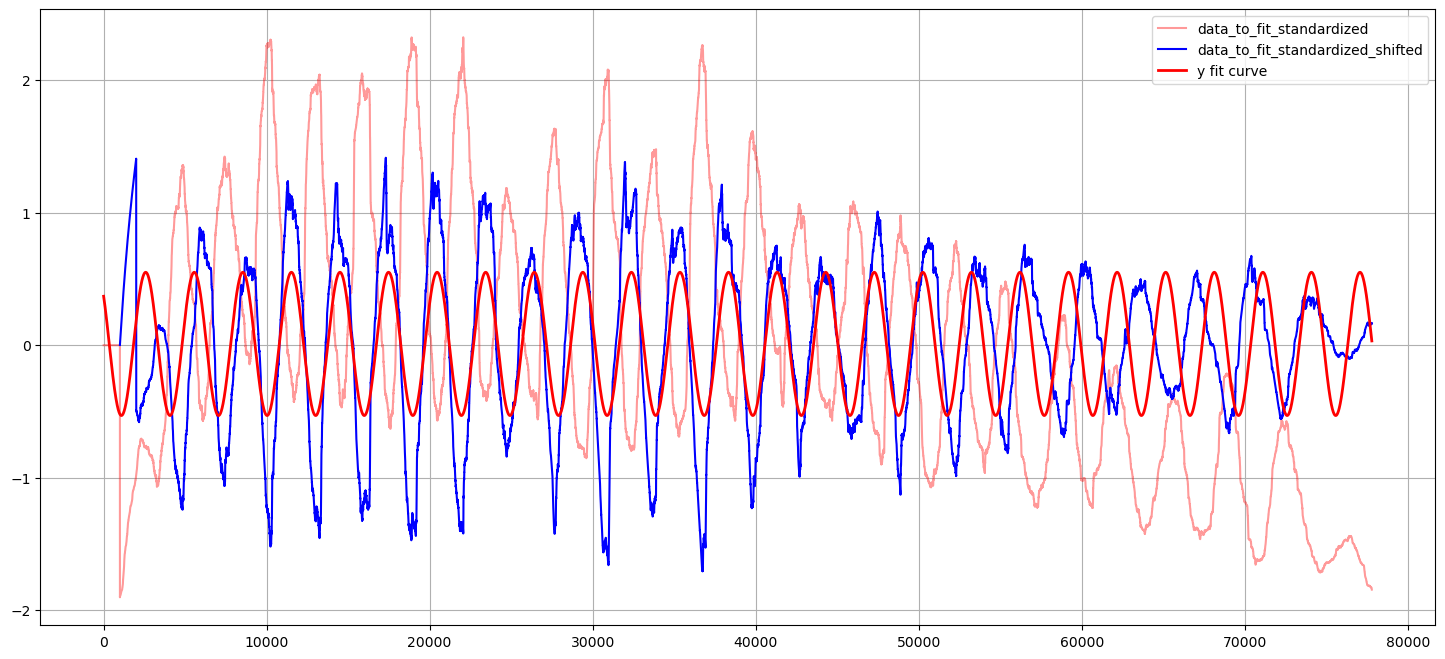

The bouncing frequency: 0.0003356194075263681	Period bounce count: 26	Period duration: 1.6207291666666668


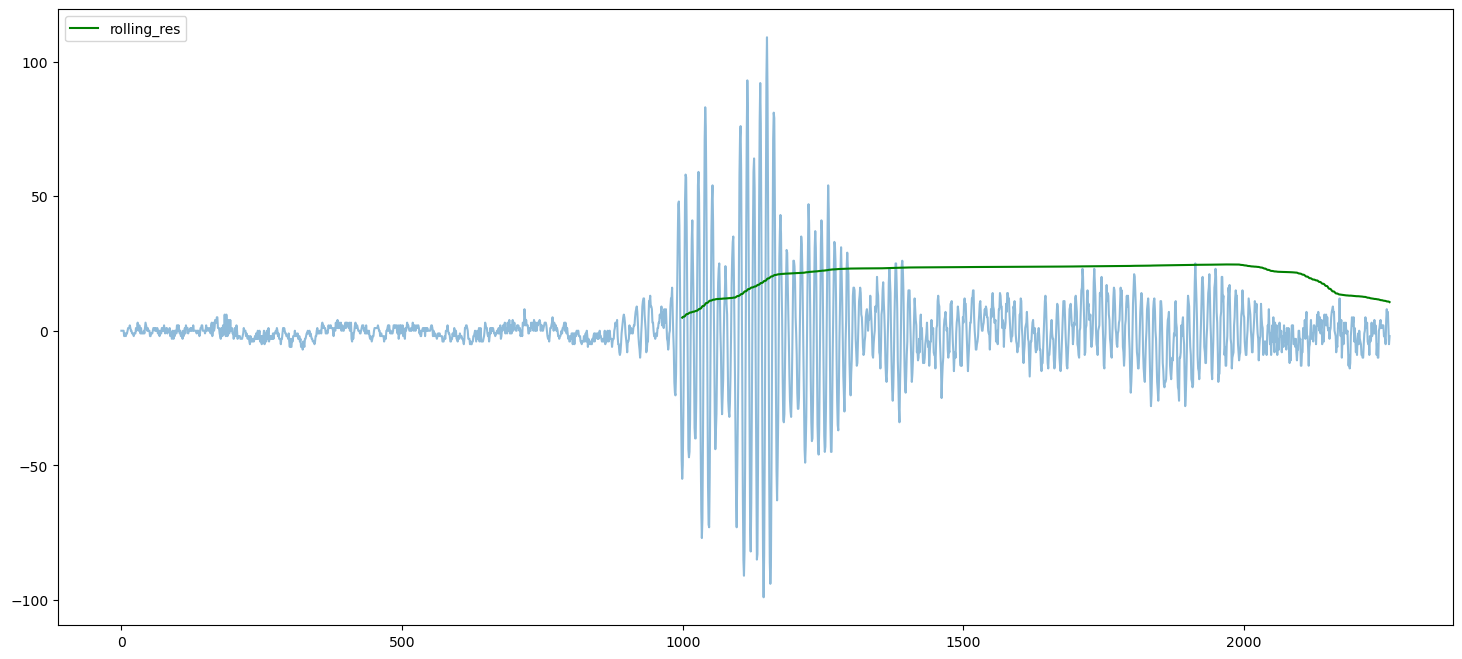

Amplitude=0.618619243409533, Angular freq.=0.003946750411767699, phase=2.6905616523354805, offset=-0.17625475977211644, Max. Cov.=0.003888044605211407


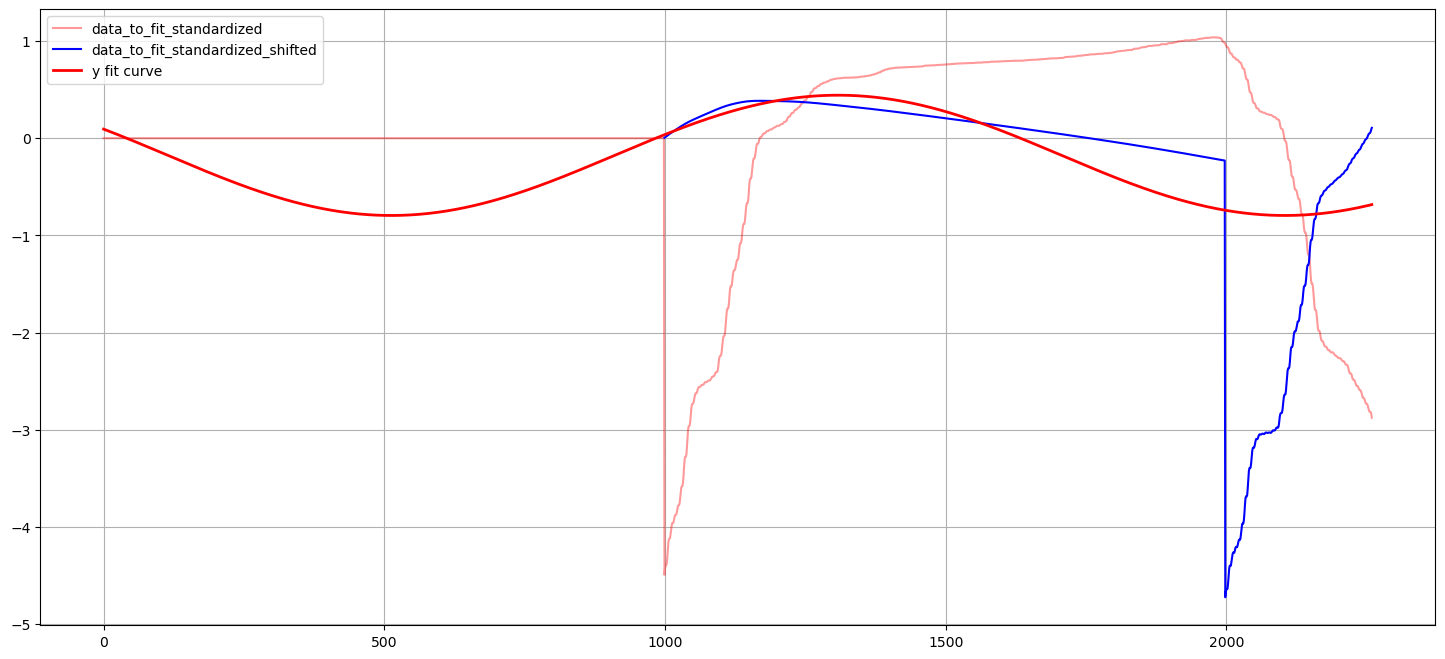

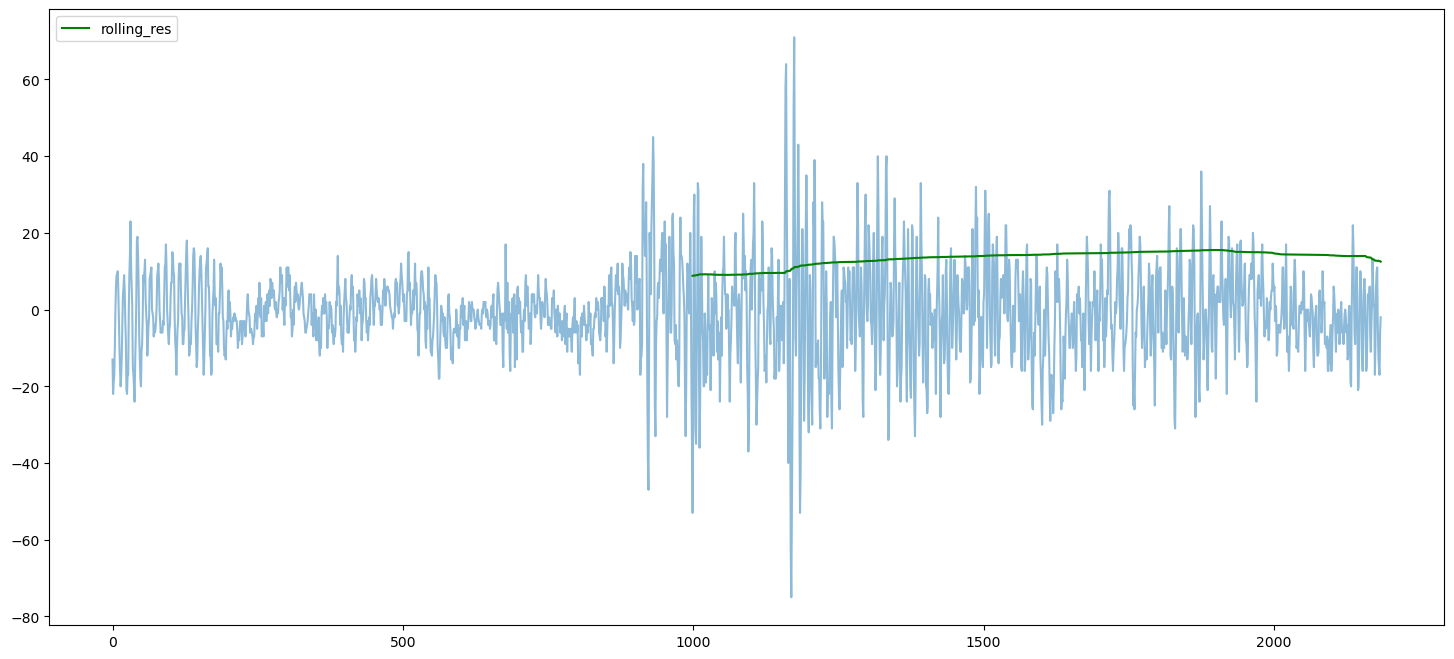

An error has occured:  Optimal parameters not found: Number of calls to function has reached maxfev = 1000.


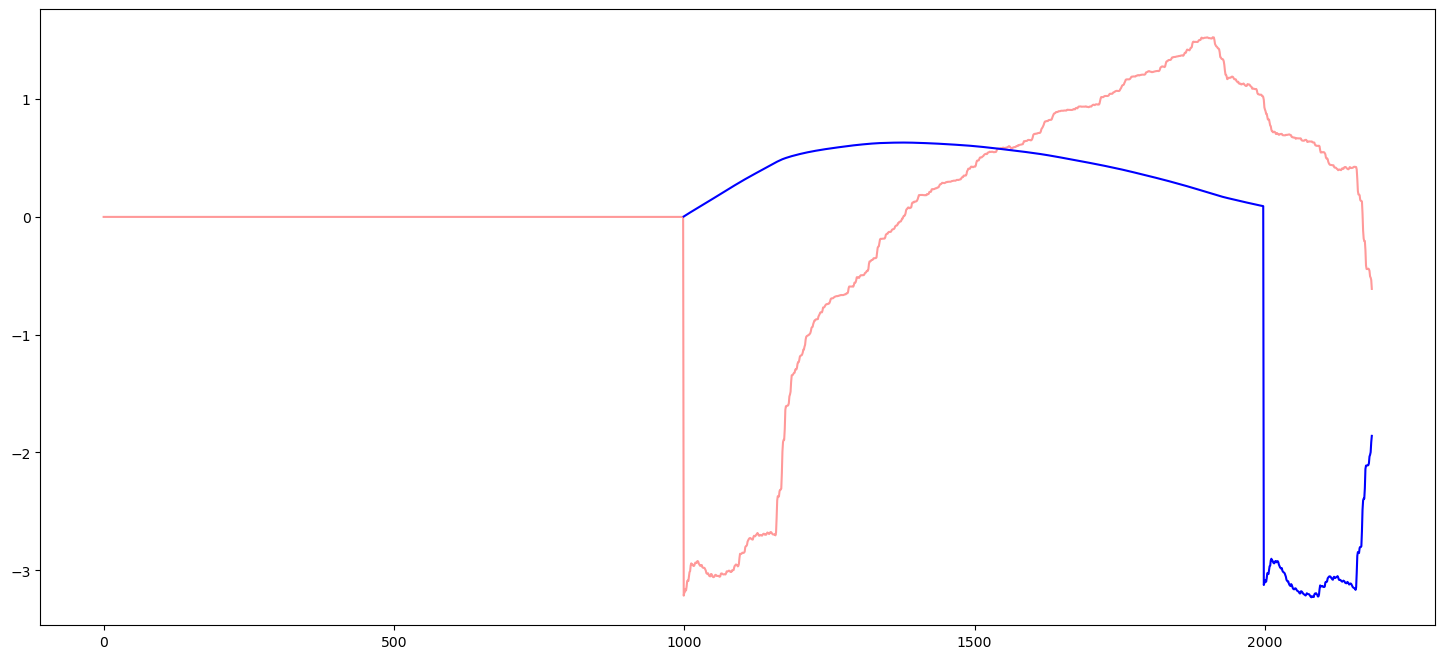

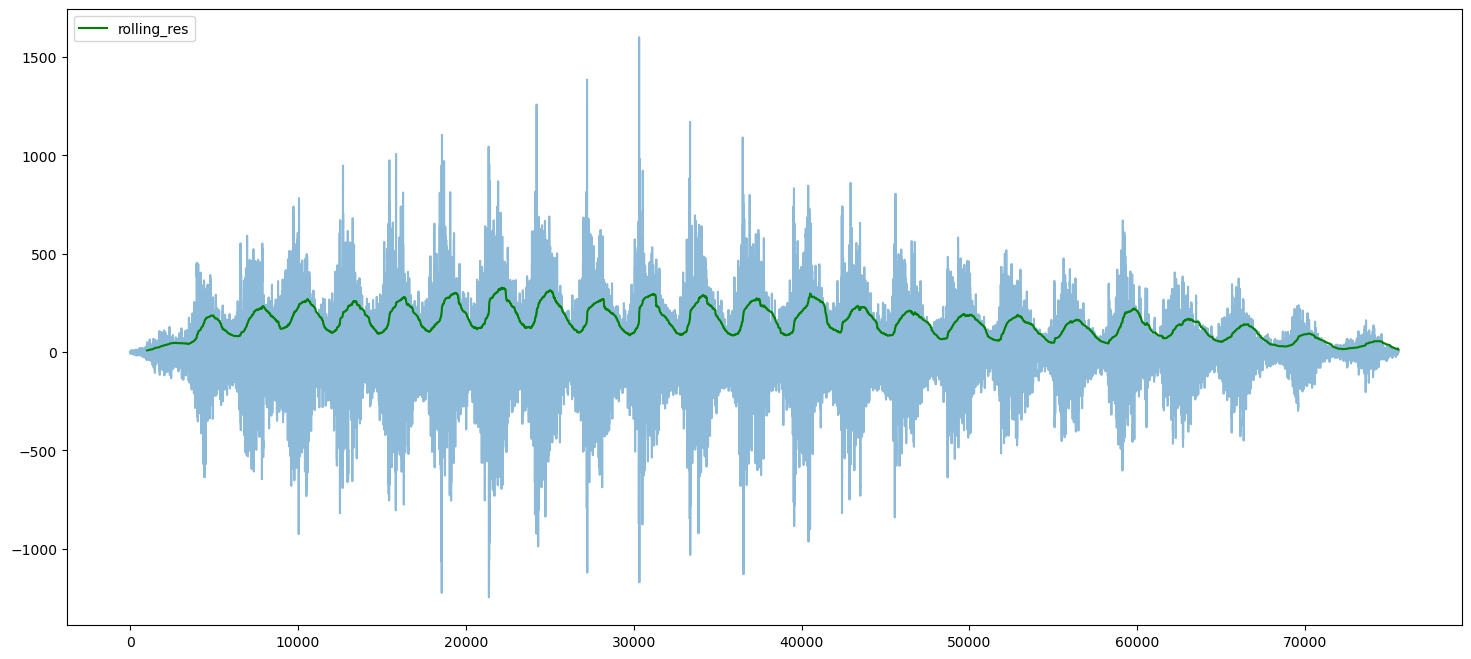

Amplitude=-0.5053907869426422, Angular freq.=0.0020522097036375997, phase=0.014233771189615621, offset=0.014319739279120614, Max. Cov.=0.00012487433682261976


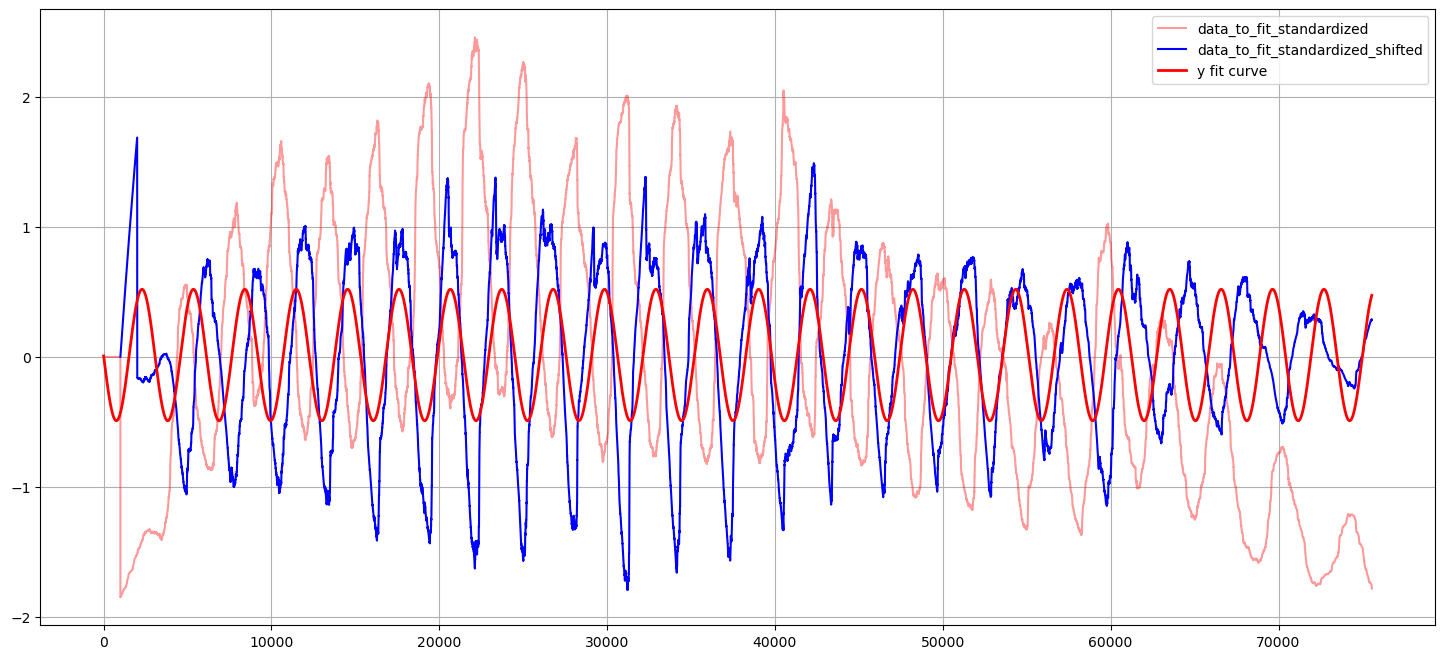

The bouncing frequency: 0.00032661931859507756	Period bounce count: 24	Period duration: 1.5741666666666667


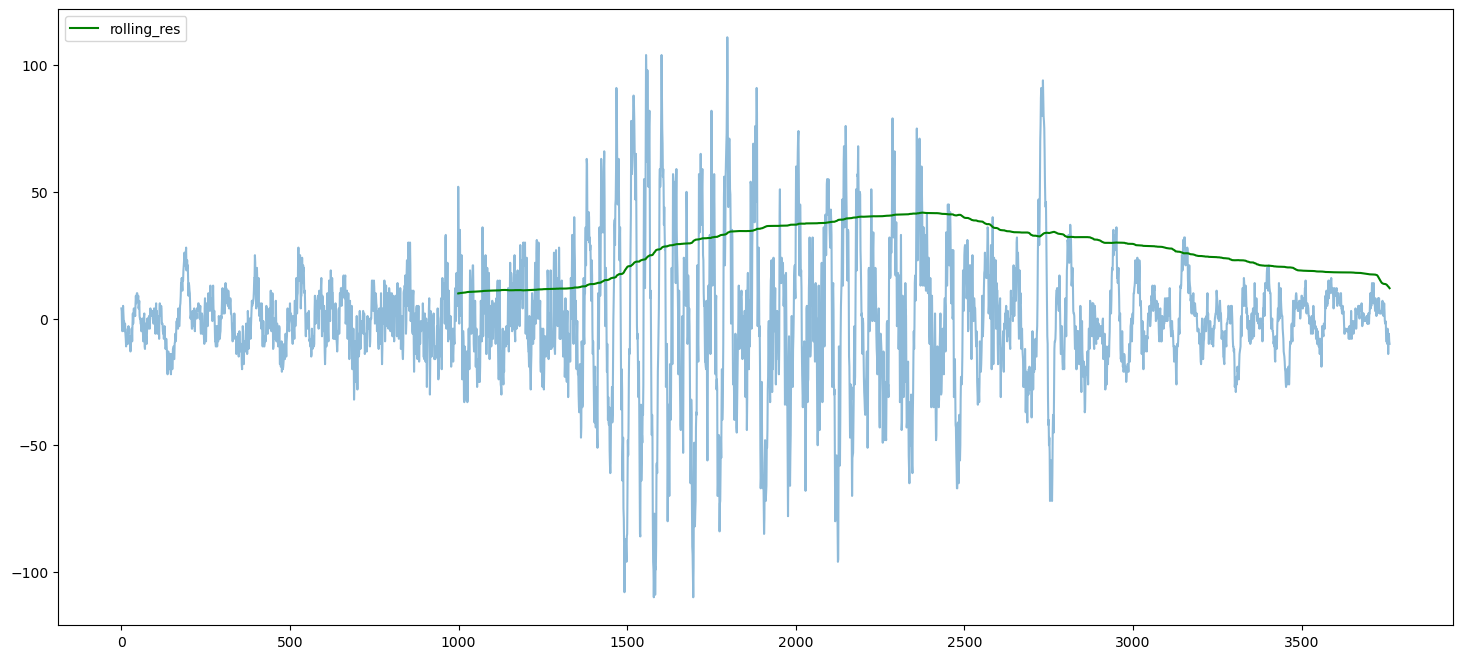

Amplitude=-1.0369247215707196, Angular freq.=0.003256623503905905, phase=-0.11154881461302513, offset=0.006659949348467497, Max. Cov.=0.0007310617658243427


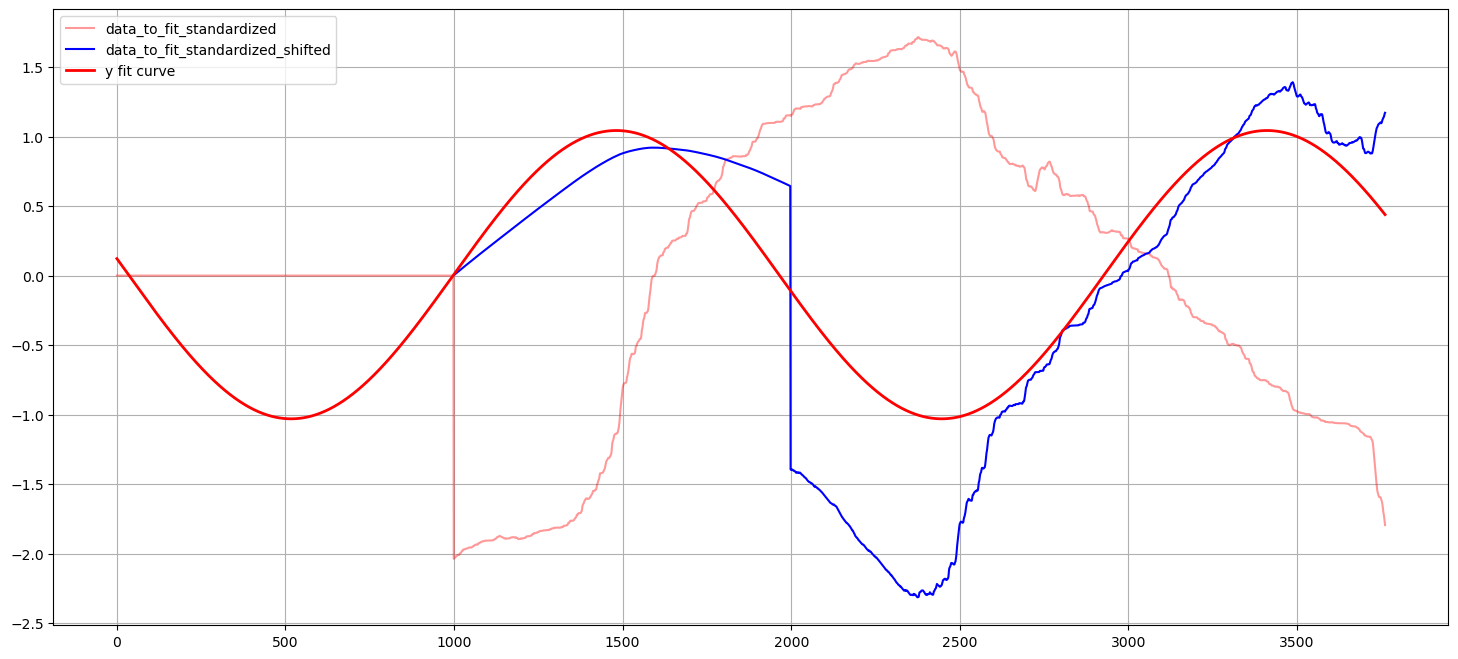

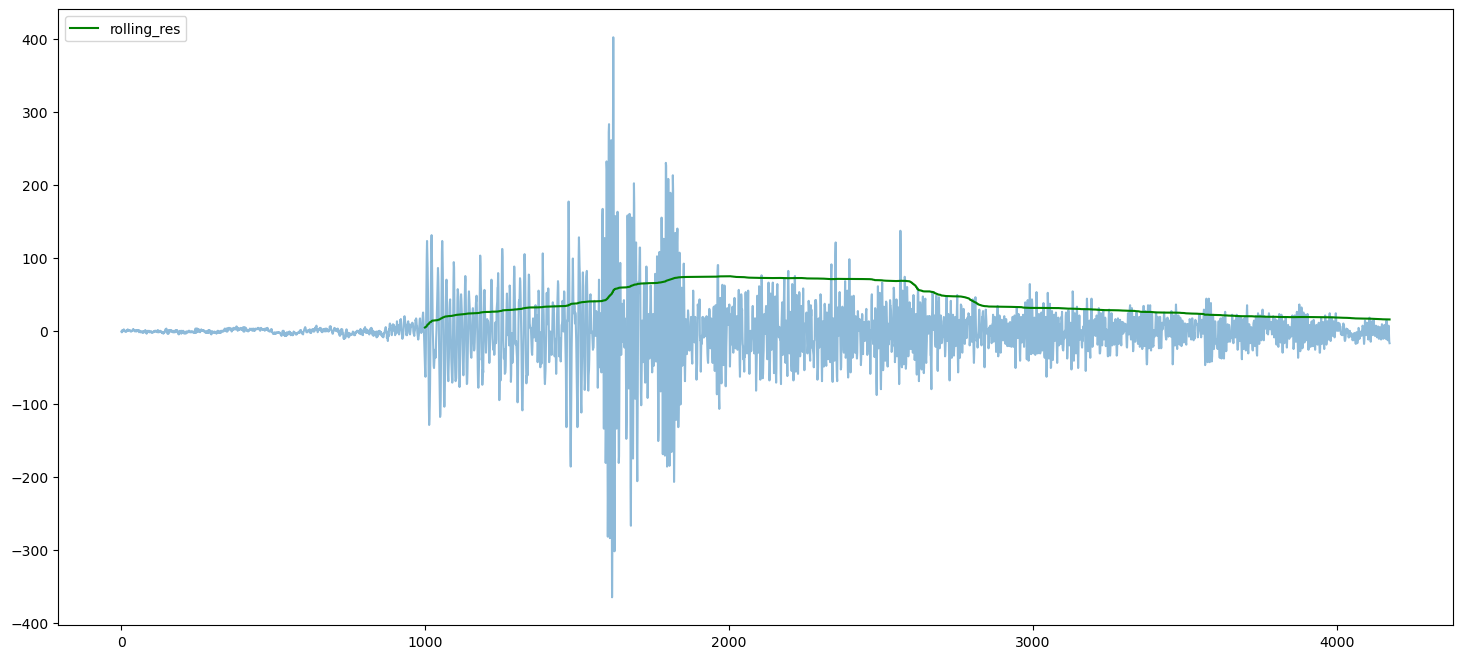

Amplitude=-1.0087714454263887, Angular freq.=0.0024511195456966115, phase=2.3703616934280625, offset=-0.021993123065344275, Max. Cov.=0.0004996705815616301


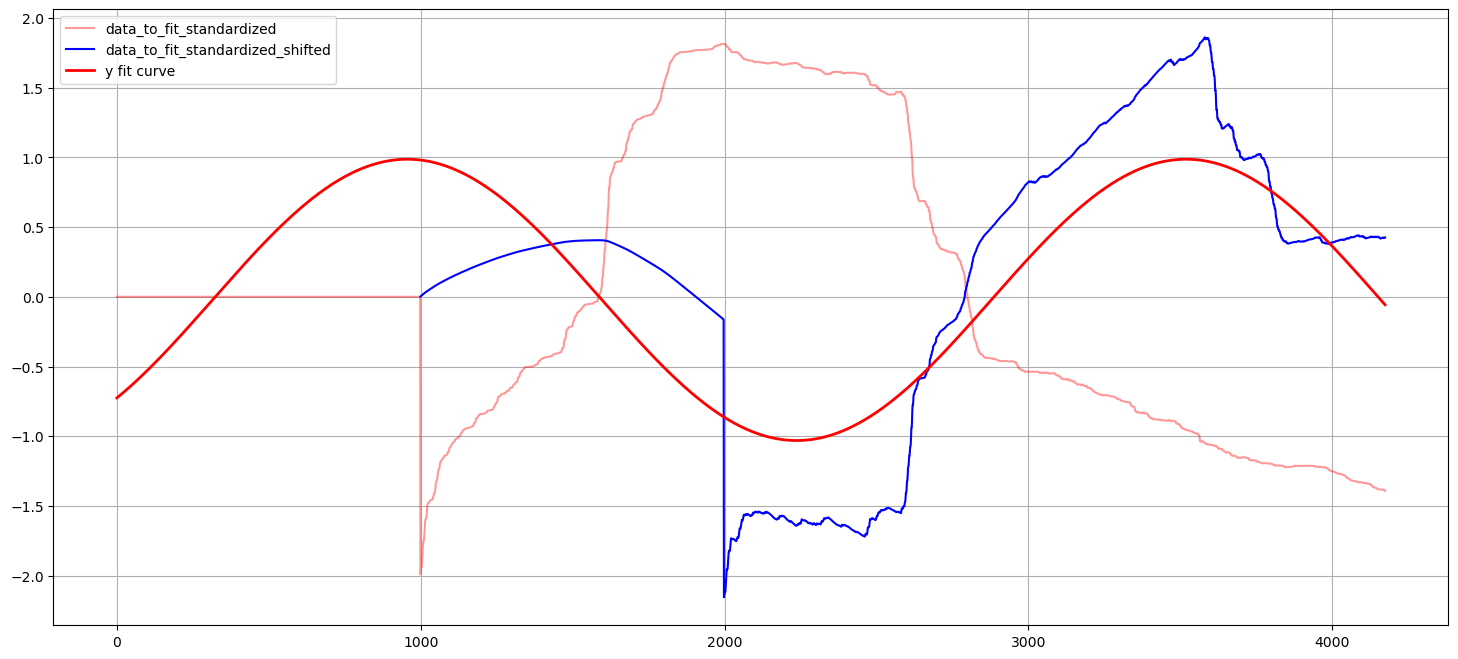

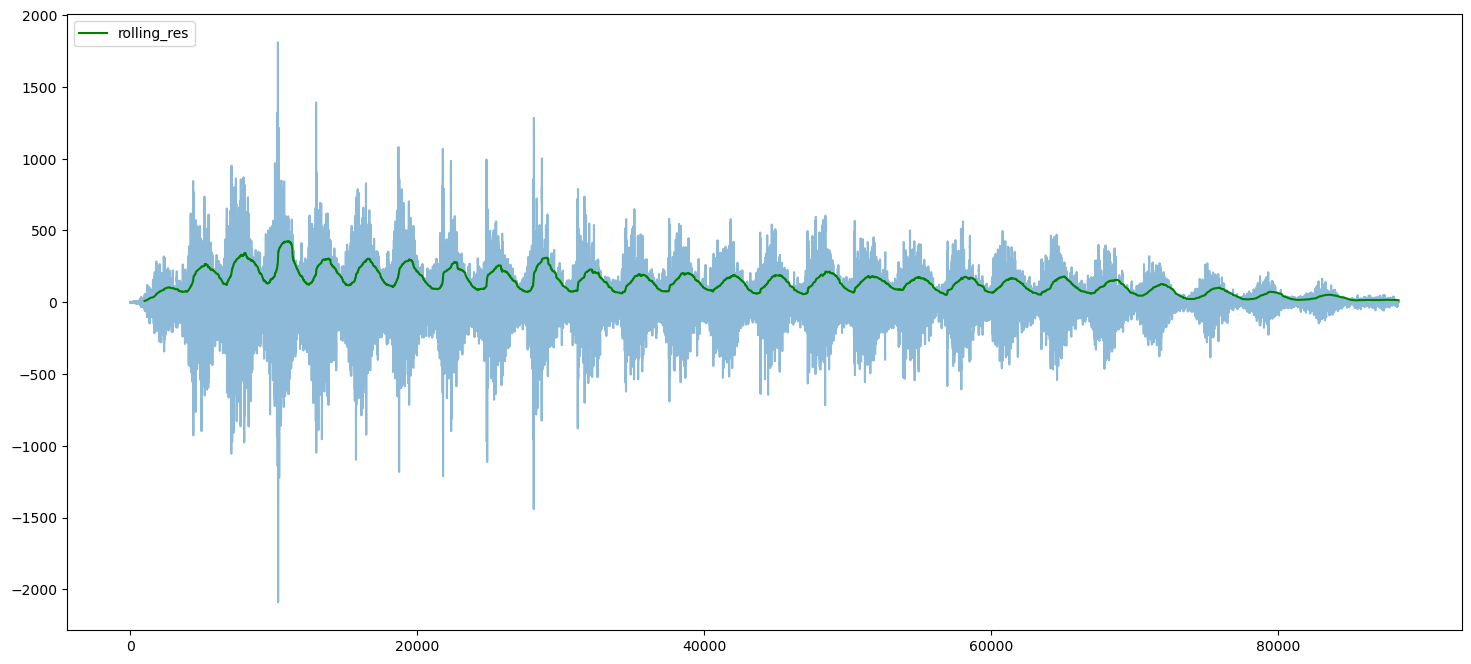

Amplitude=-0.3671343645429673, Angular freq.=0.001968515087076335, phase=0.46449613726962485, offset=0.00998960453565542, Max. Cov.=0.00018777508810915146


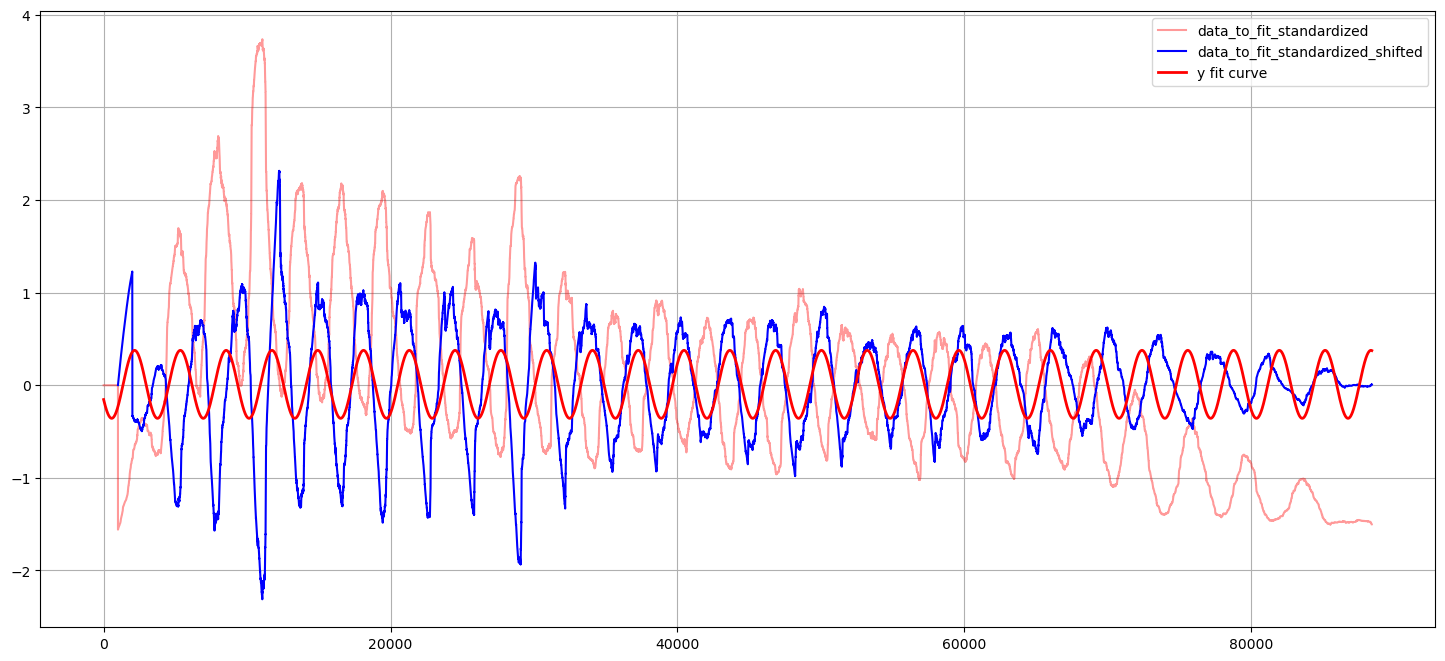

The bouncing frequency: 0.0003132989066591715	Period bounce count: 27	Period duration: 1.8416666666666666


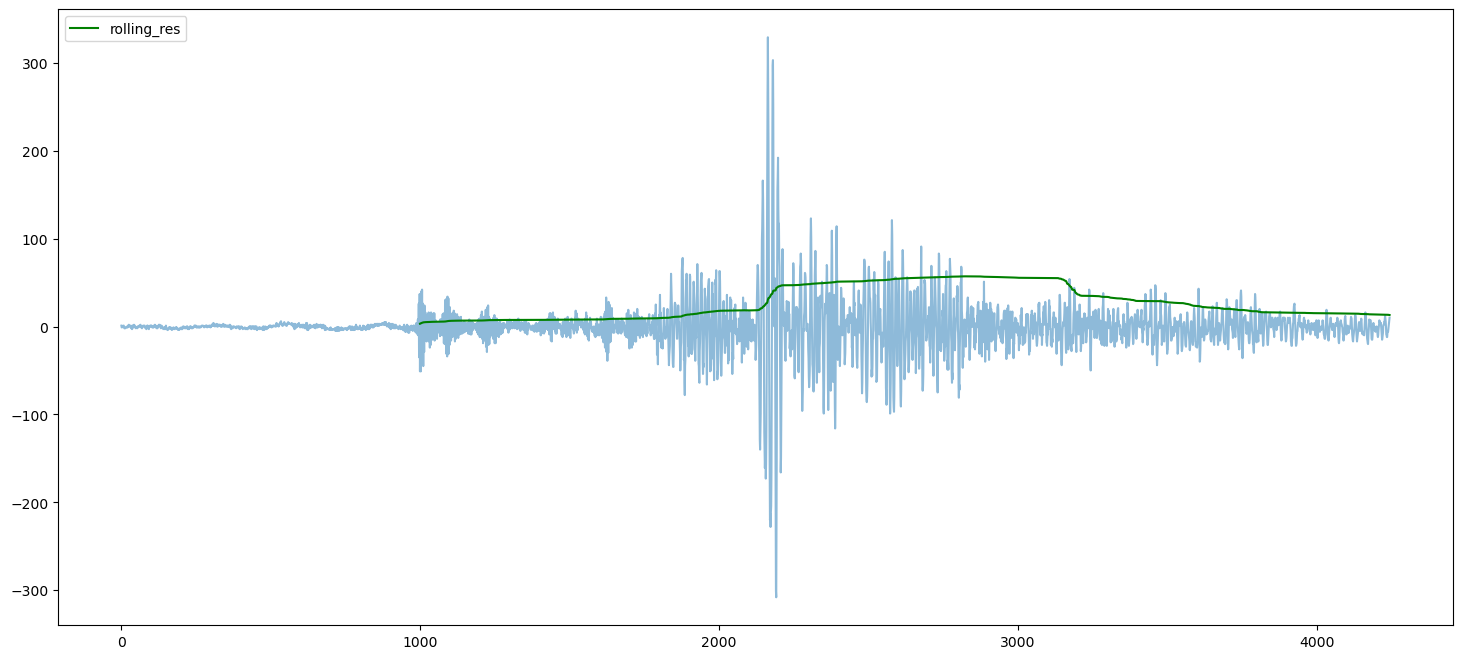

Amplitude=-1.0025555012845269, Angular freq.=0.002627413565510631, phase=0.4718289833756243, offset=0.05082757668199668, Max. Cov.=0.0007381892396736054


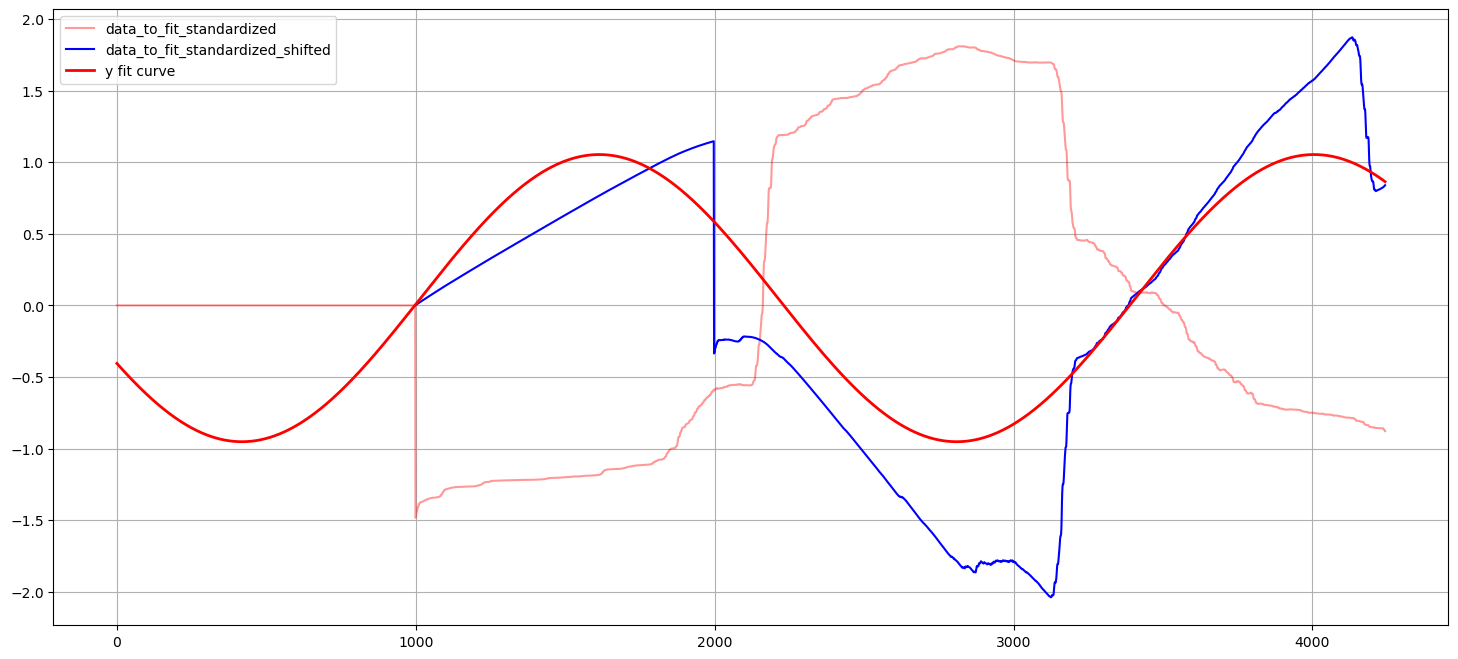

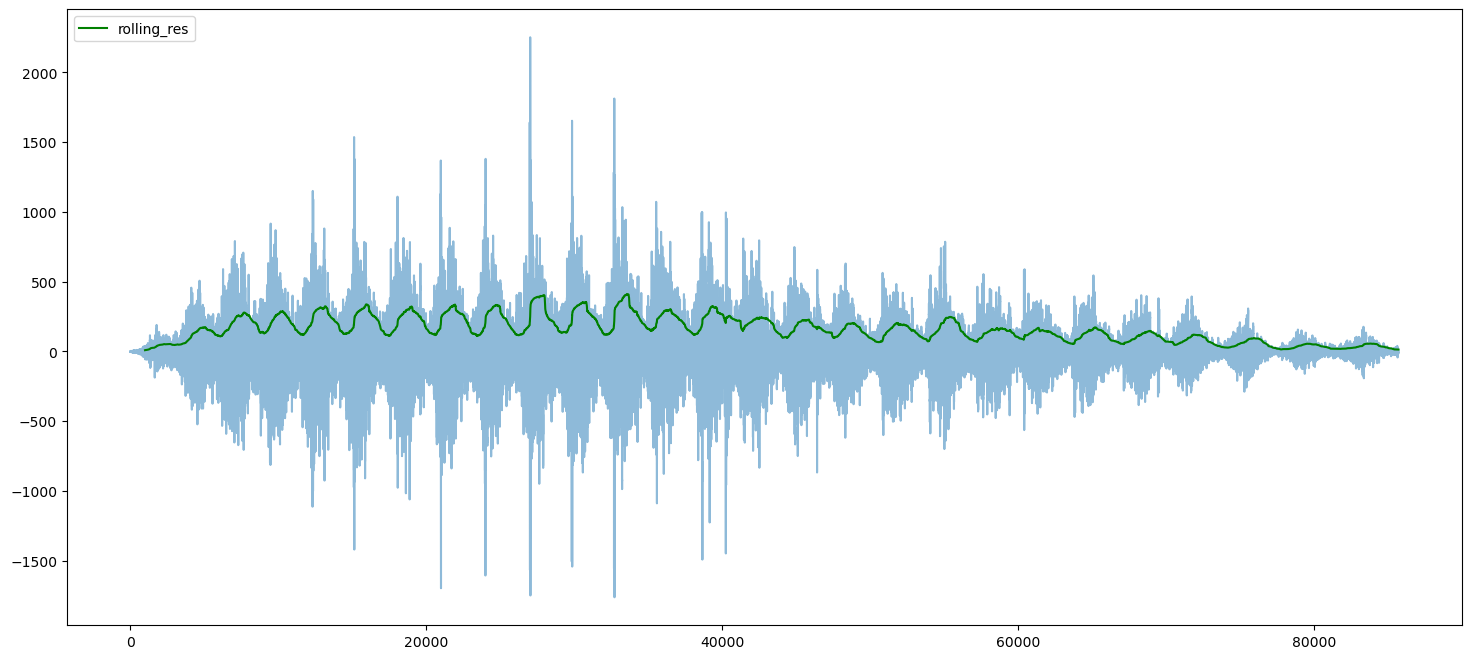

Amplitude=-0.4140444281893047, Angular freq.=0.0021098710333798346, phase=-0.45122010231572923, offset=0.011375717780531654, Max. Cov.=0.00012740743409310262


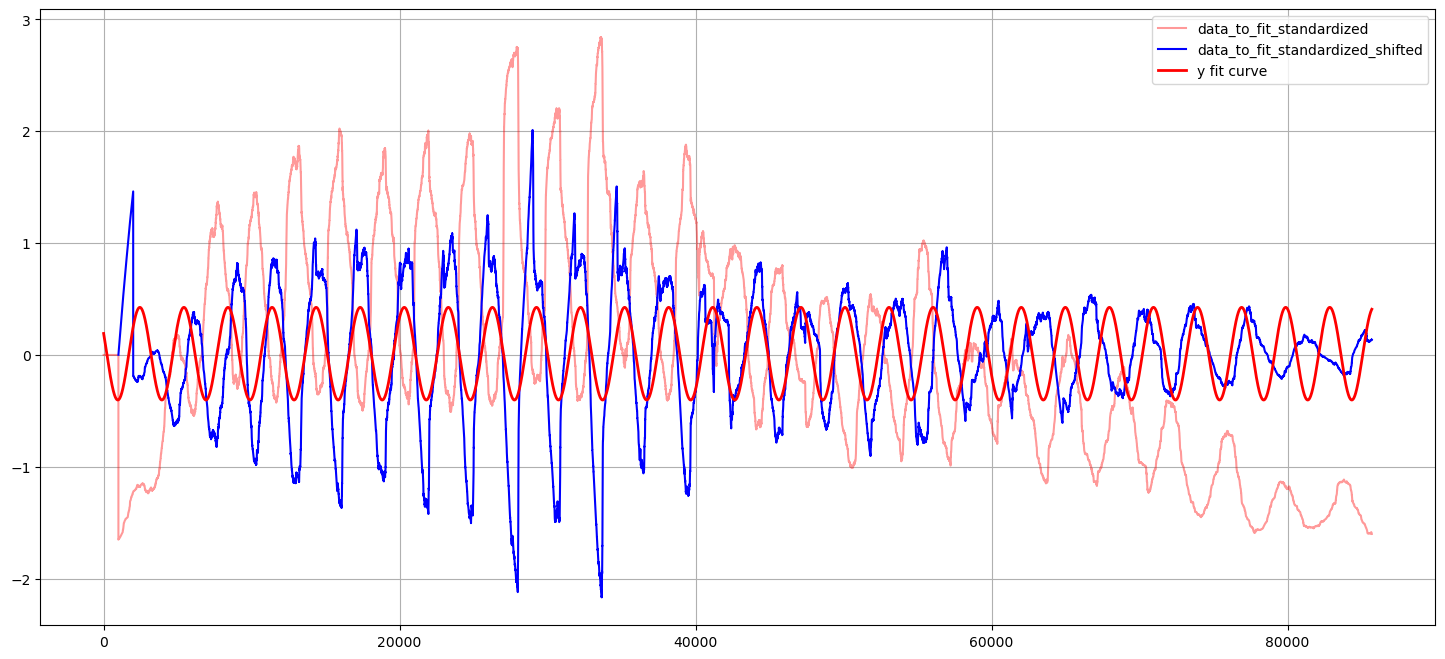

The bouncing frequency: 0.000335796404248806	Period bounce count: 28	Period duration: 1.7853333333333334


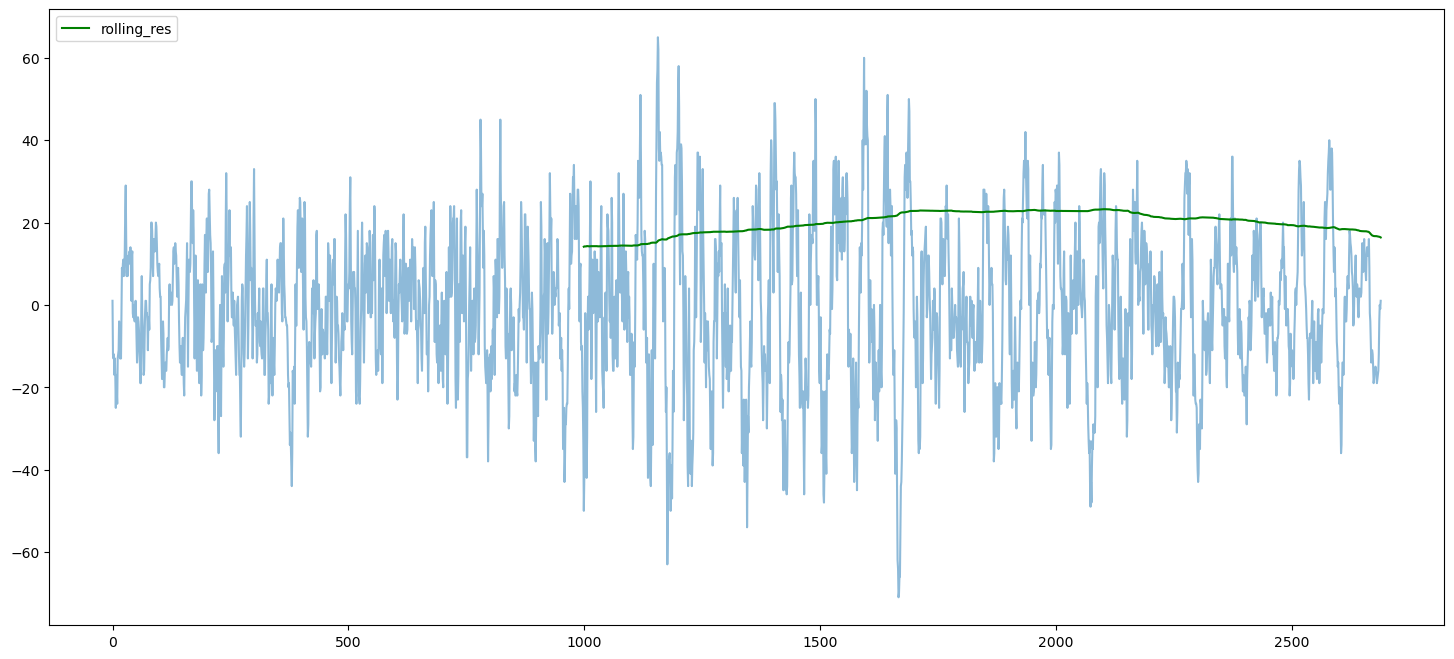

Amplitude=1.0233310224811472, Angular freq.=0.0036697742843321483, phase=-3.5731322642431977, offset=-0.12755069106536995, Max. Cov.=0.0010288299071170067


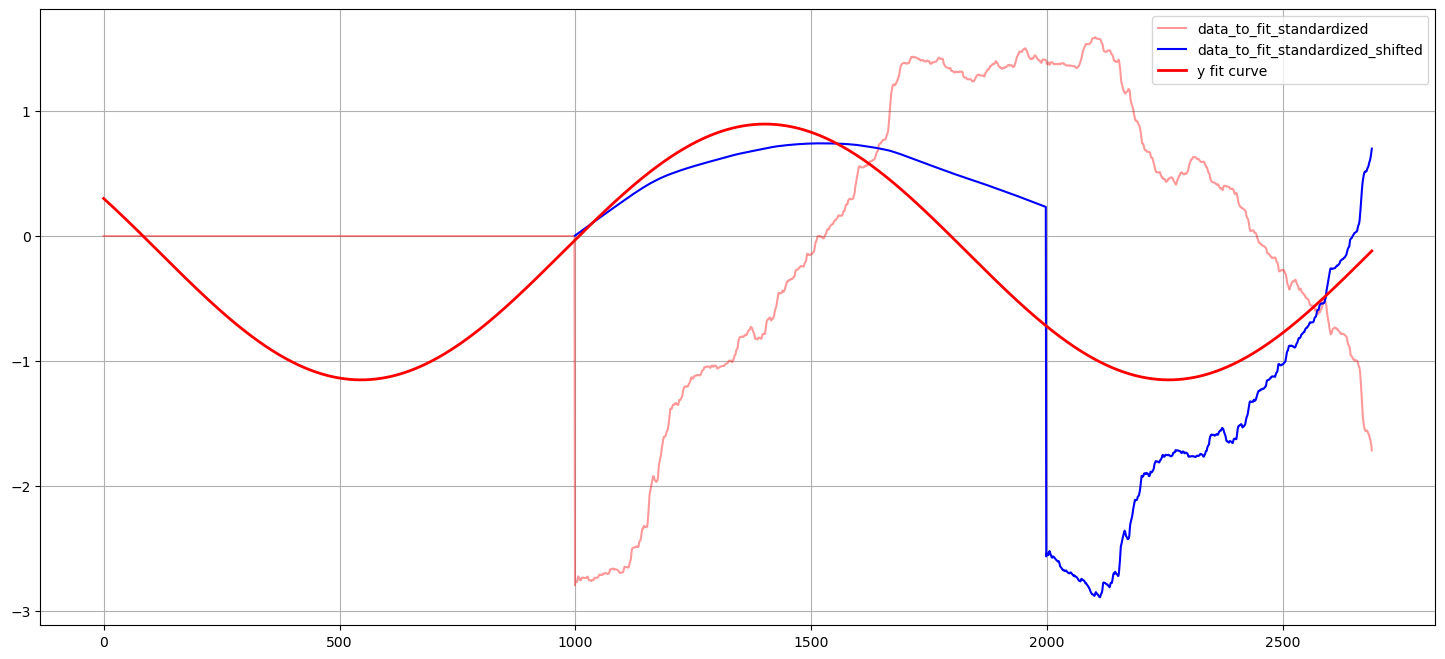

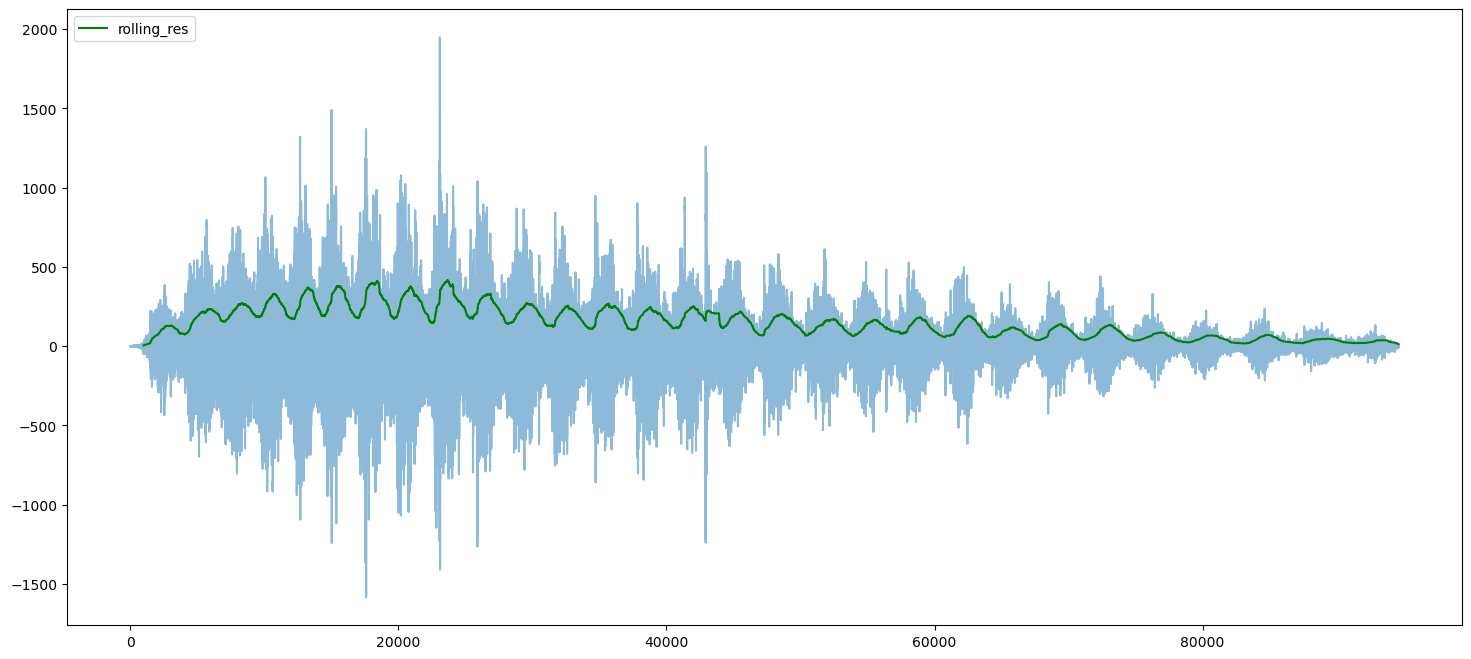

Amplitude=0.20086175611597928, Angular freq.=0.0020766643621324245, phase=-0.8119967579983322, offset=0.006578954254391216, Max. Cov.=0.00037402761564282006


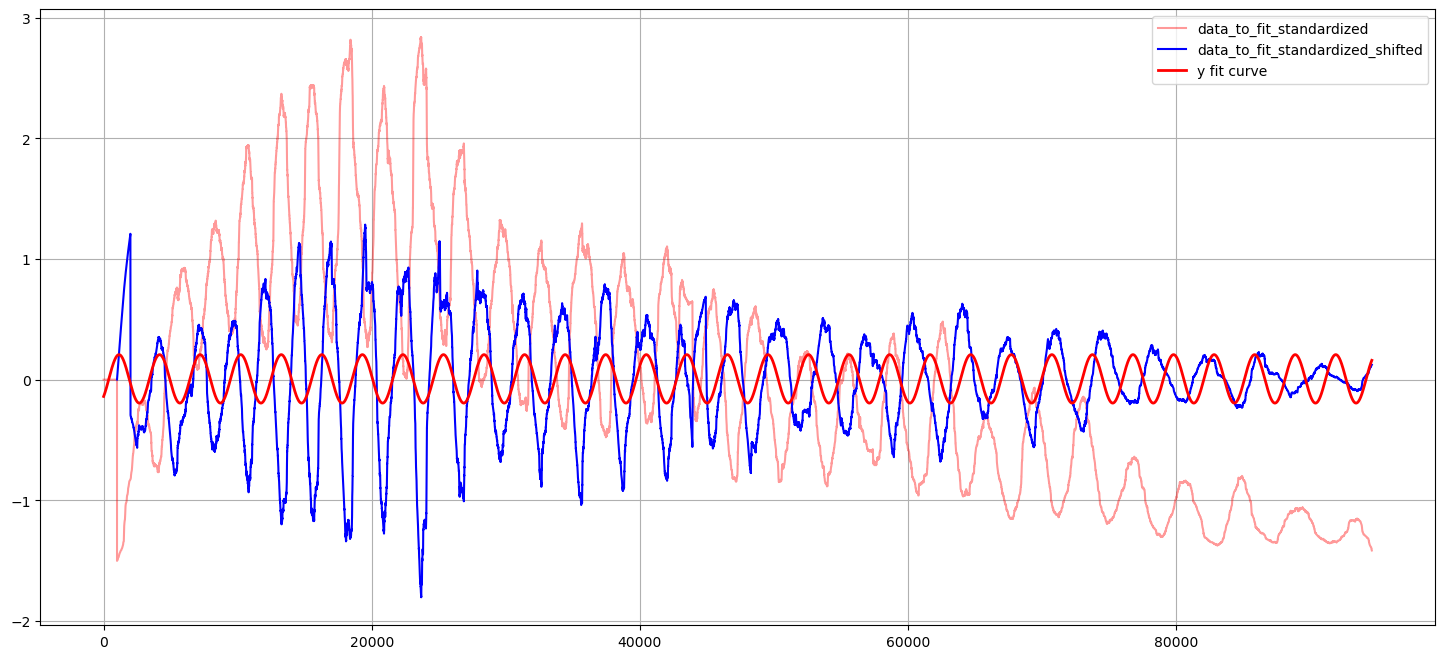

The bouncing frequency: 0.00033051139837615316	Period bounce count: 31	Period duration: 1.9709375


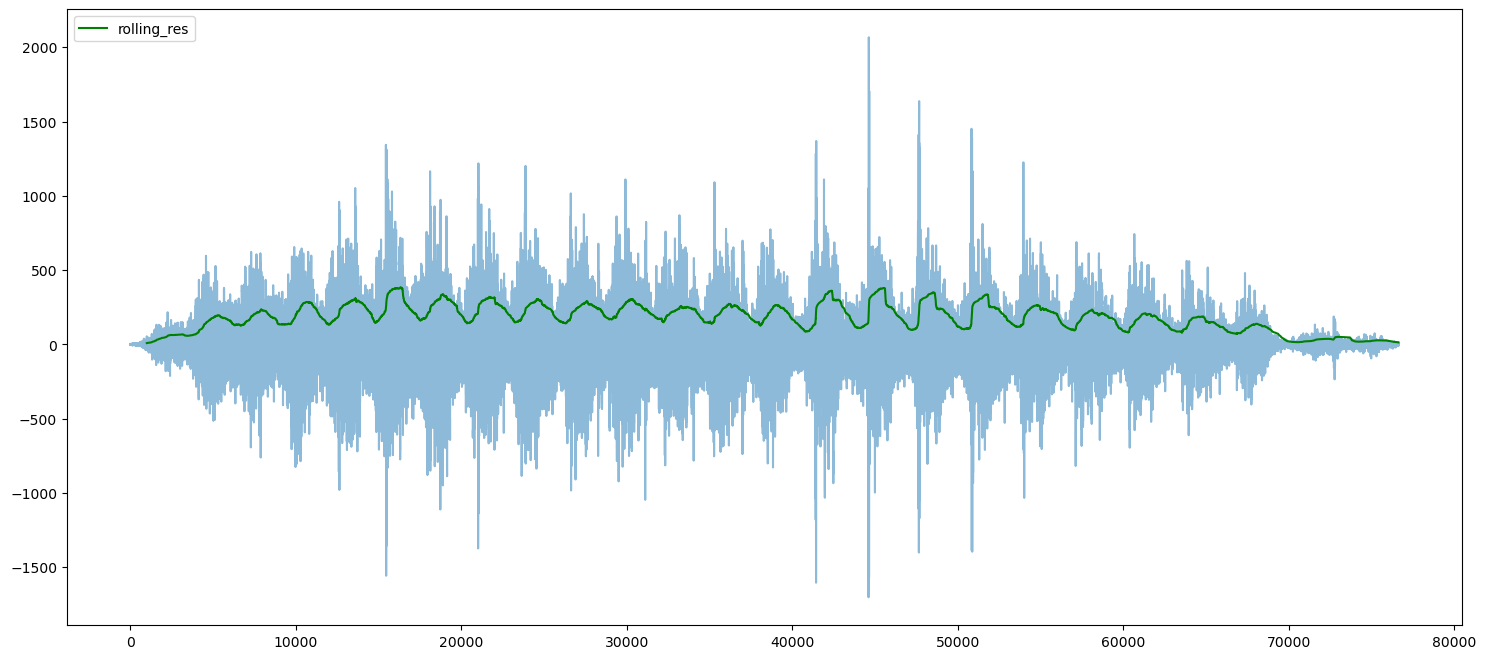

Amplitude=-0.38265240960255903, Angular freq.=0.002177443461016384, phase=-2.4222005441639305, offset=0.009116742532913301, Max. Cov.=0.00020624085298177934


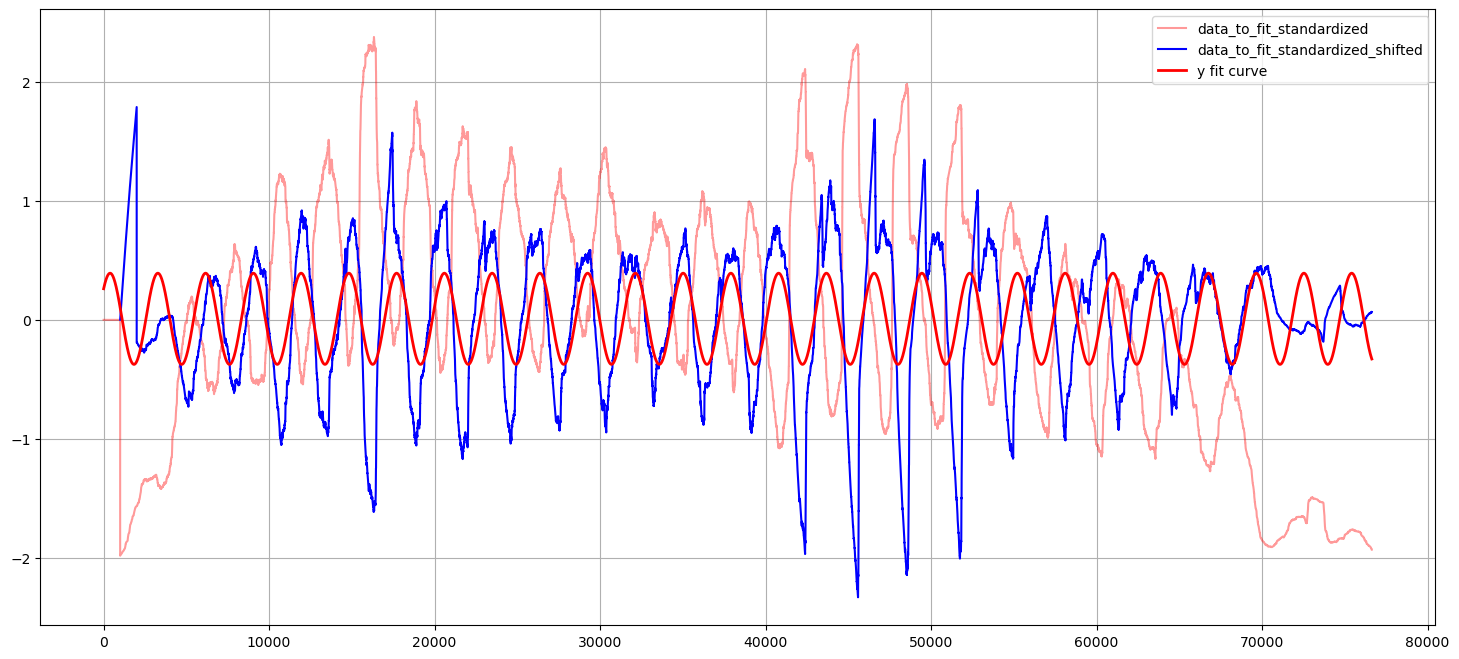

The bouncing frequency: 0.00034655089012388226	Period bounce count: 26	Period duration: 1.5965416666666667


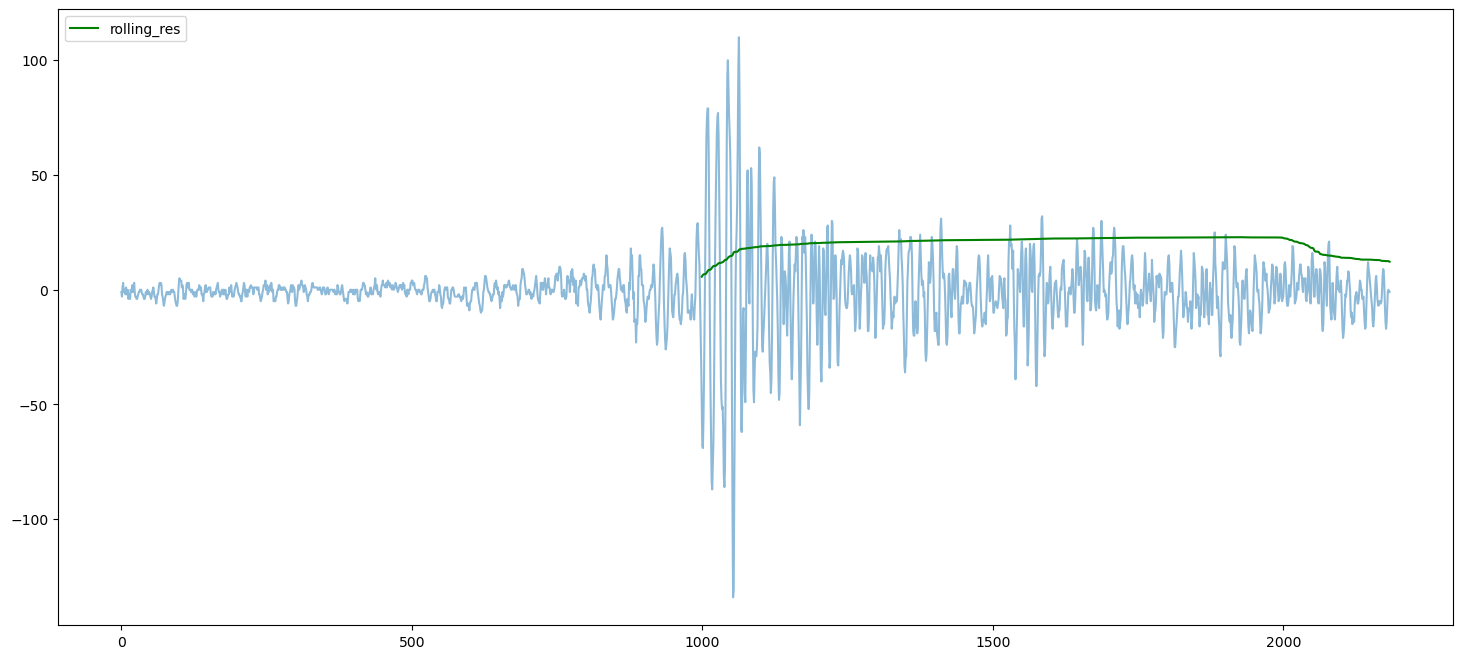

Amplitude=0.4832527500825924, Angular freq.=0.00397413231267217, phase=2.6961386286032507, offset=-0.15662051931327559, Max. Cov.=0.005405071234007645


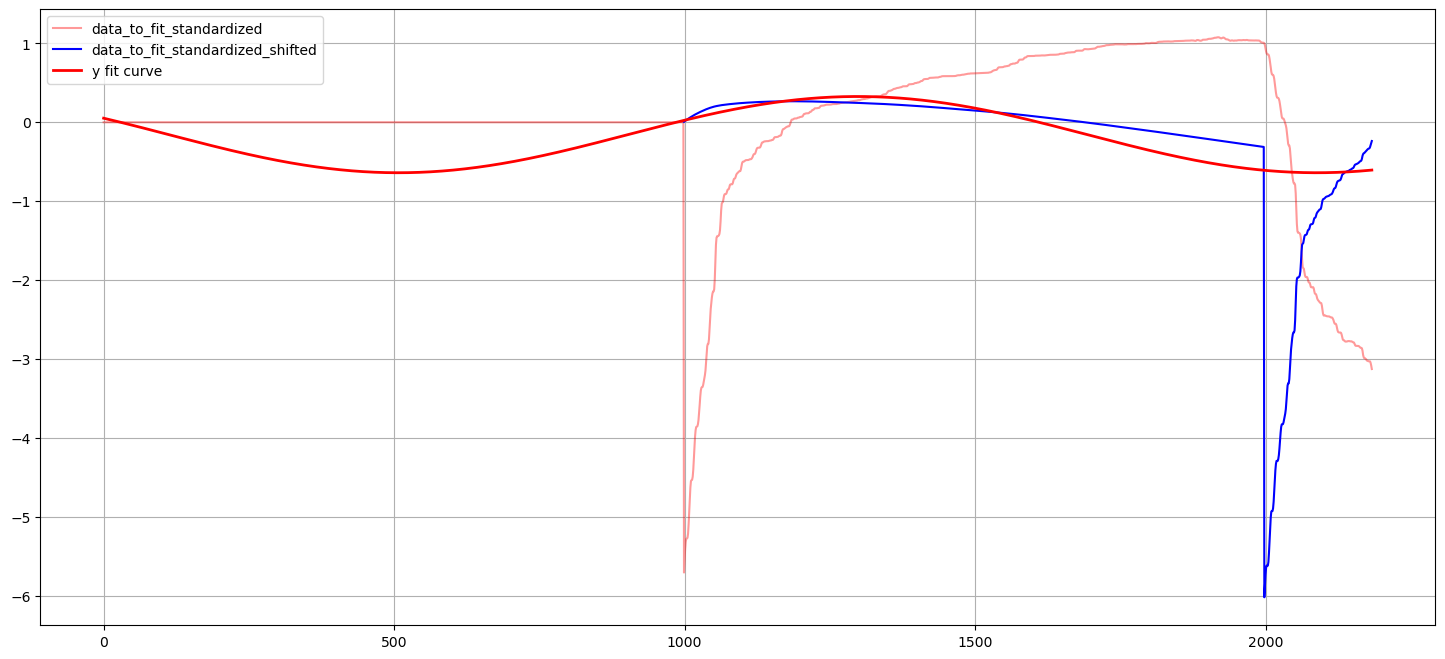

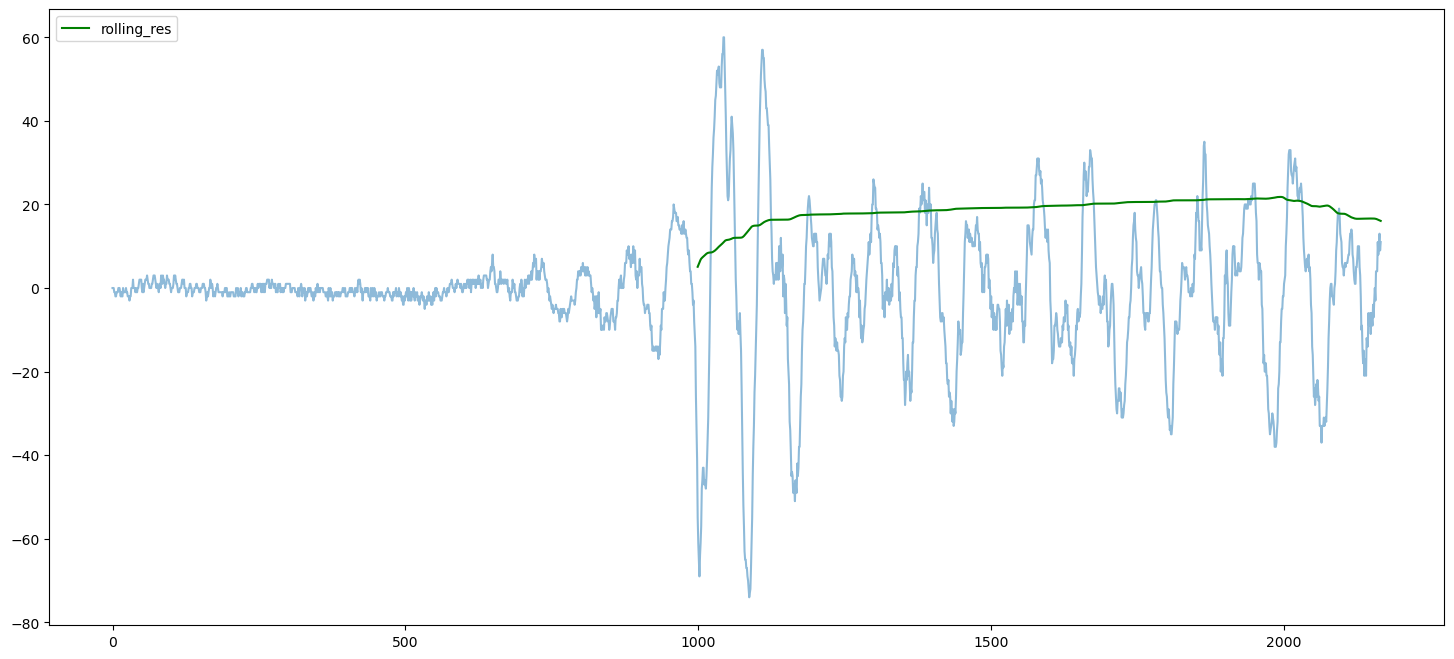

Amplitude=0.684268781248498, Angular freq.=0.003935524757346019, phase=2.573032119162223, offset=-0.03770974330047546, Max. Cov.=0.00435784118258587


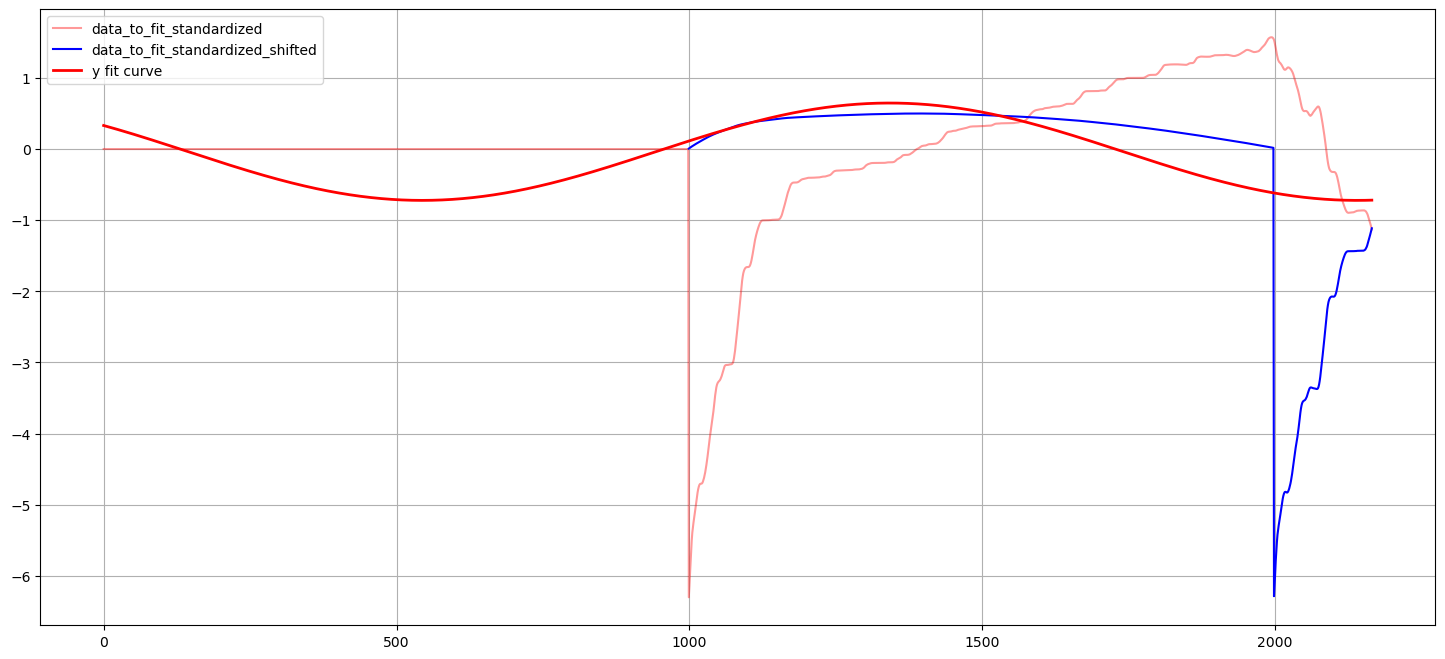

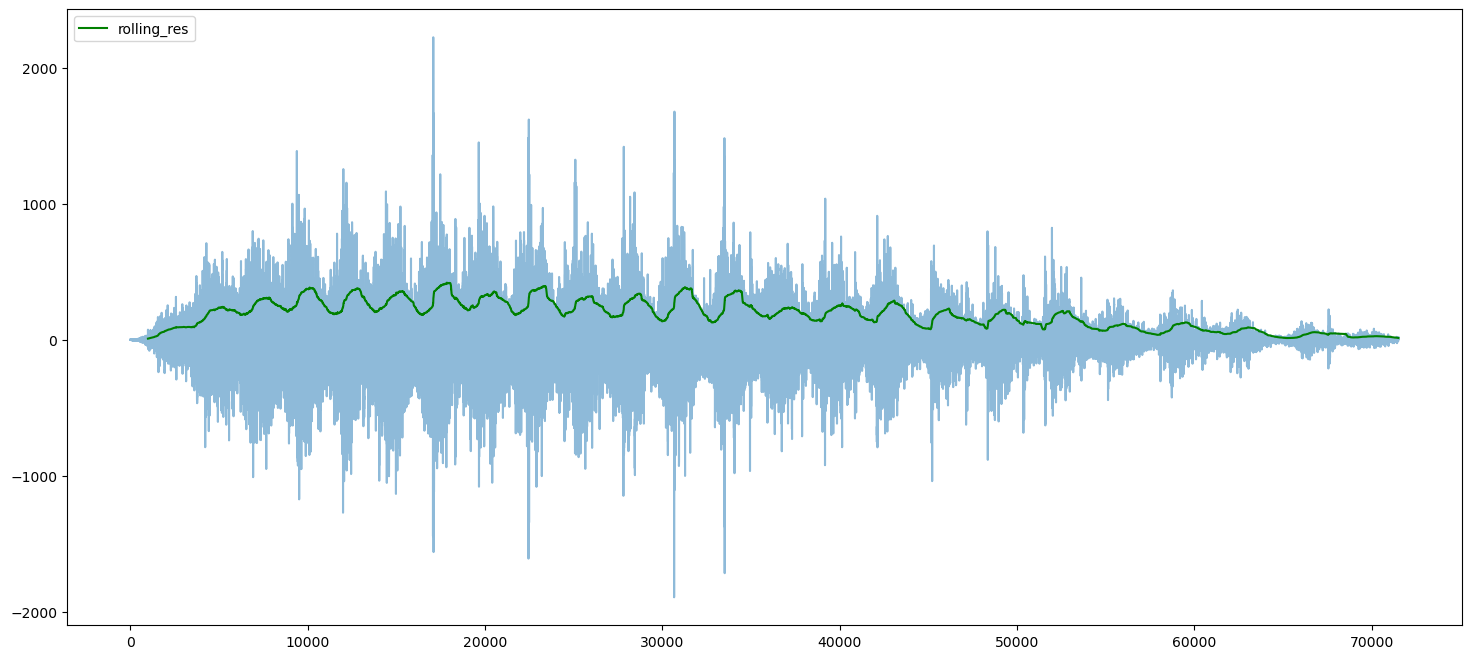

Amplitude=0.29028451608487715, Angular freq.=0.002334259282813916, phase=0.33457162342408725, offset=0.008158821224325246, Max. Cov.=0.00025725430435314913


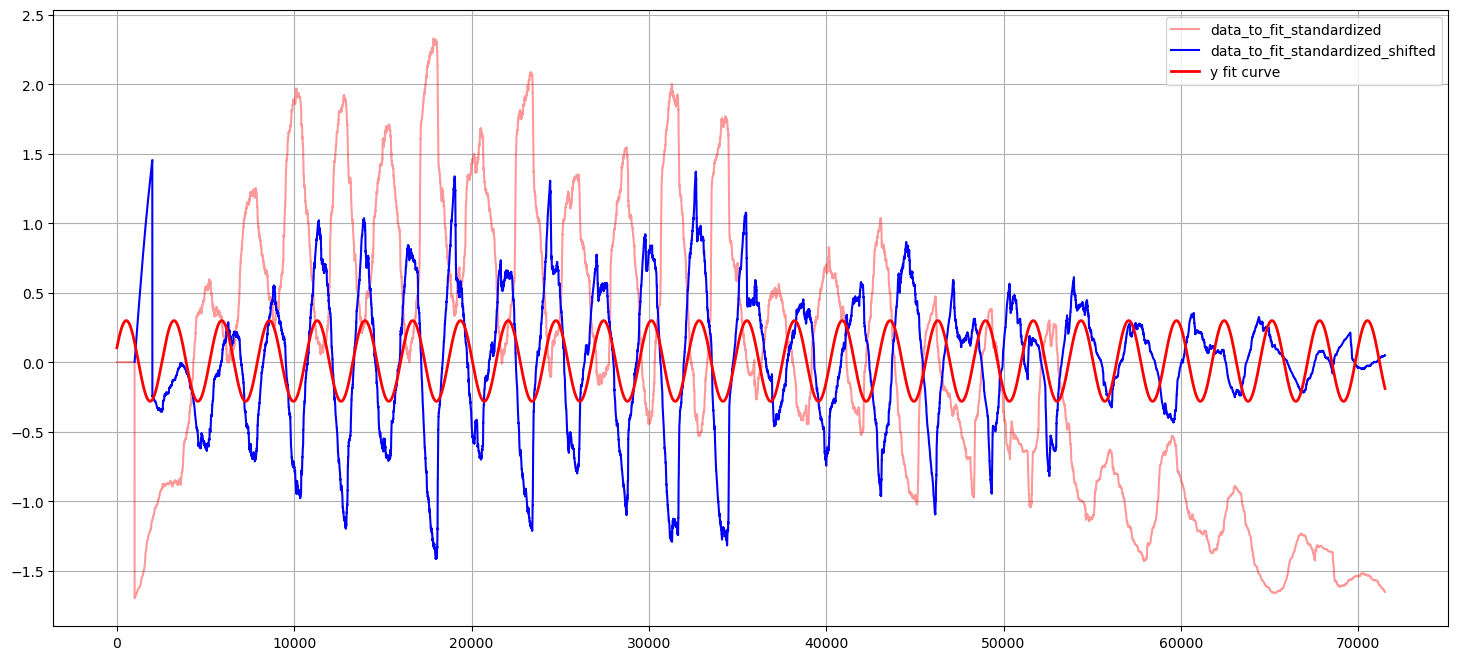

The bouncing frequency: 0.0003715089033179772	Period bounce count: 26	Period duration: 1.4897916666666666


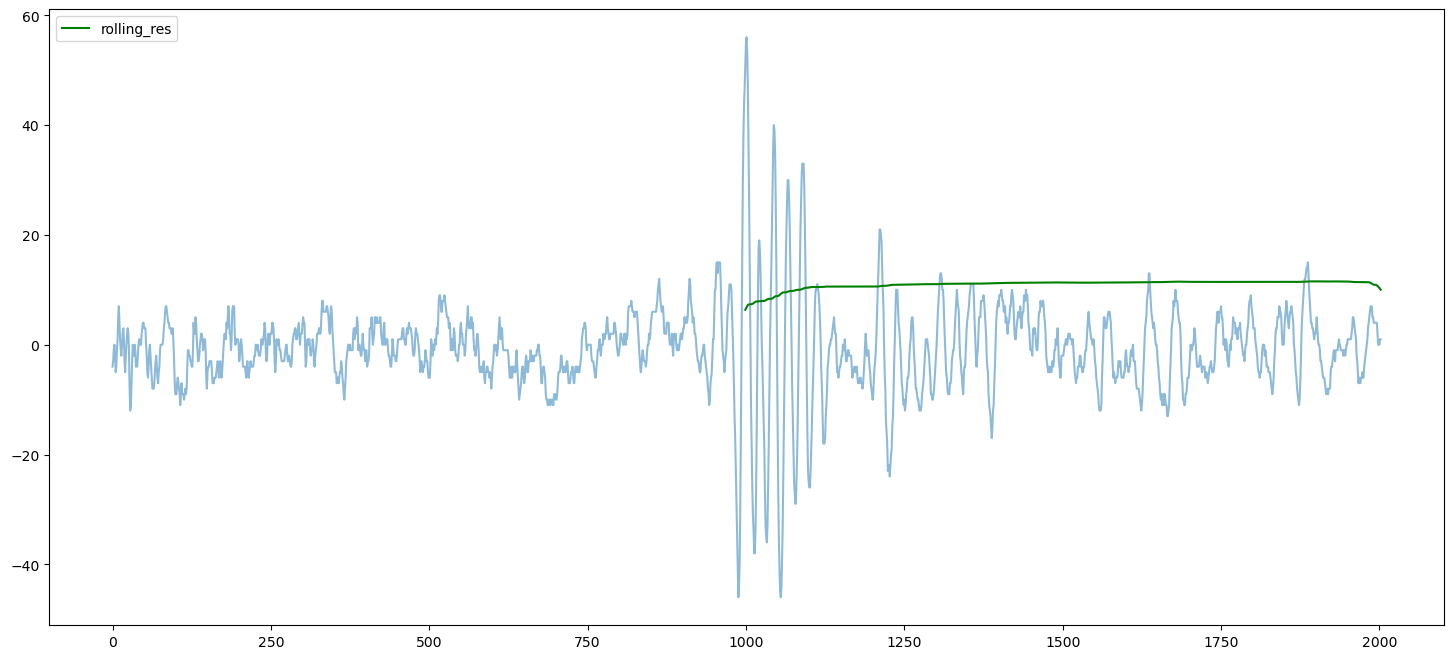

Amplitude=-0.14653973542083581, Angular freq.=0.0042686738658055945, phase=-0.7439526126334668, offset=0.25867509786090026, Max. Cov.=0.02065769251013754


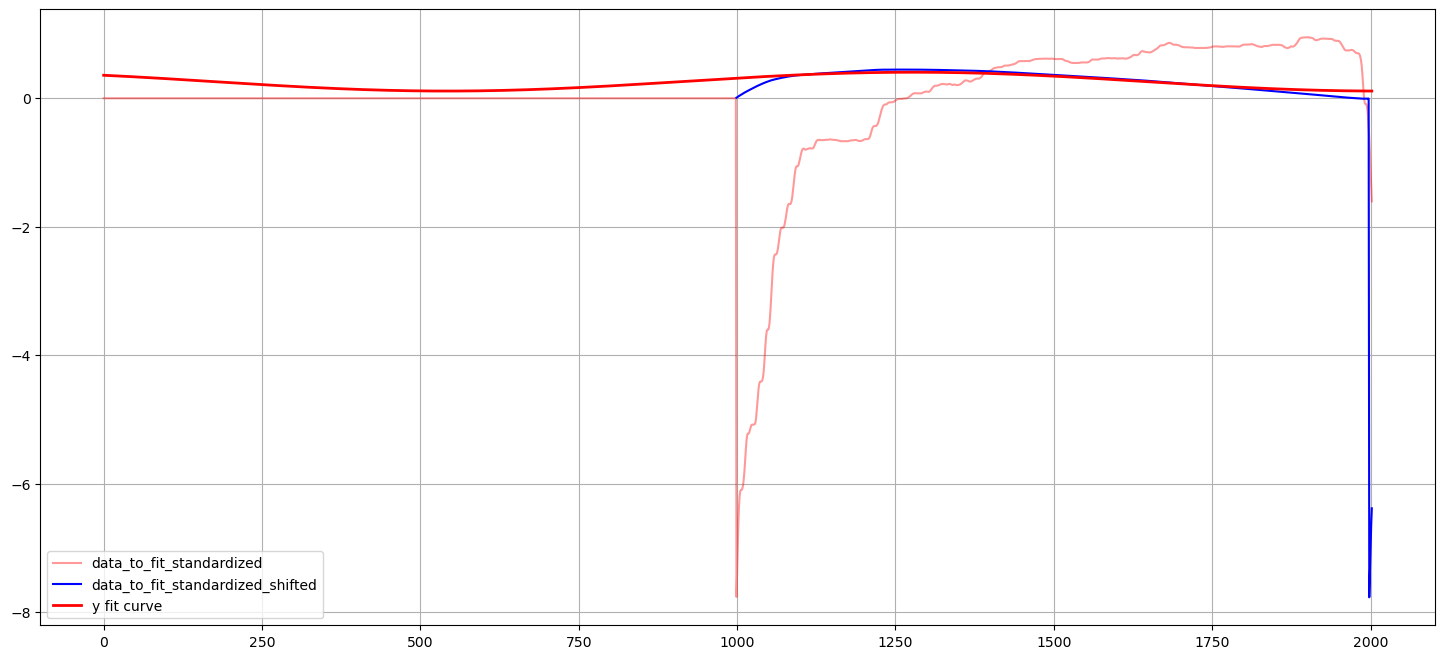

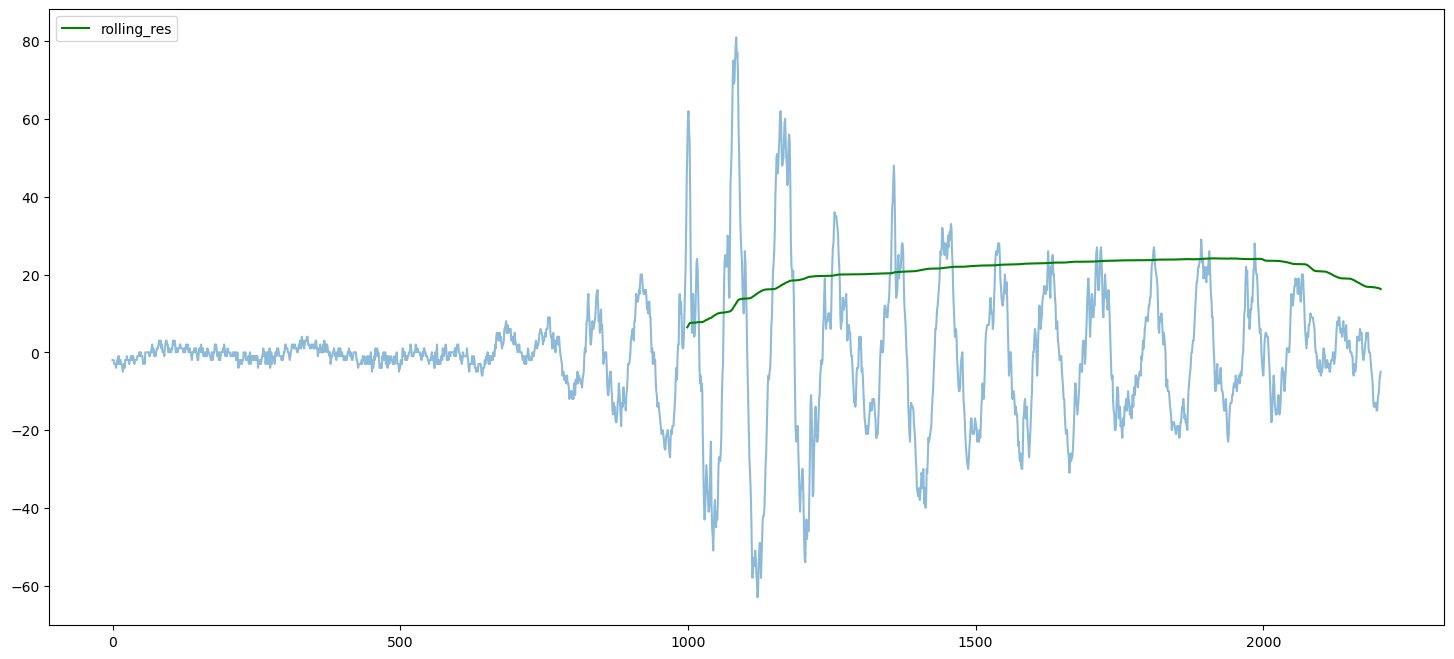

Amplitude=0.7702792970899417, Angular freq.=0.003895793231627718, phase=2.6185333886780287, offset=-0.08727522208470416, Max. Cov.=0.0032687962556093002


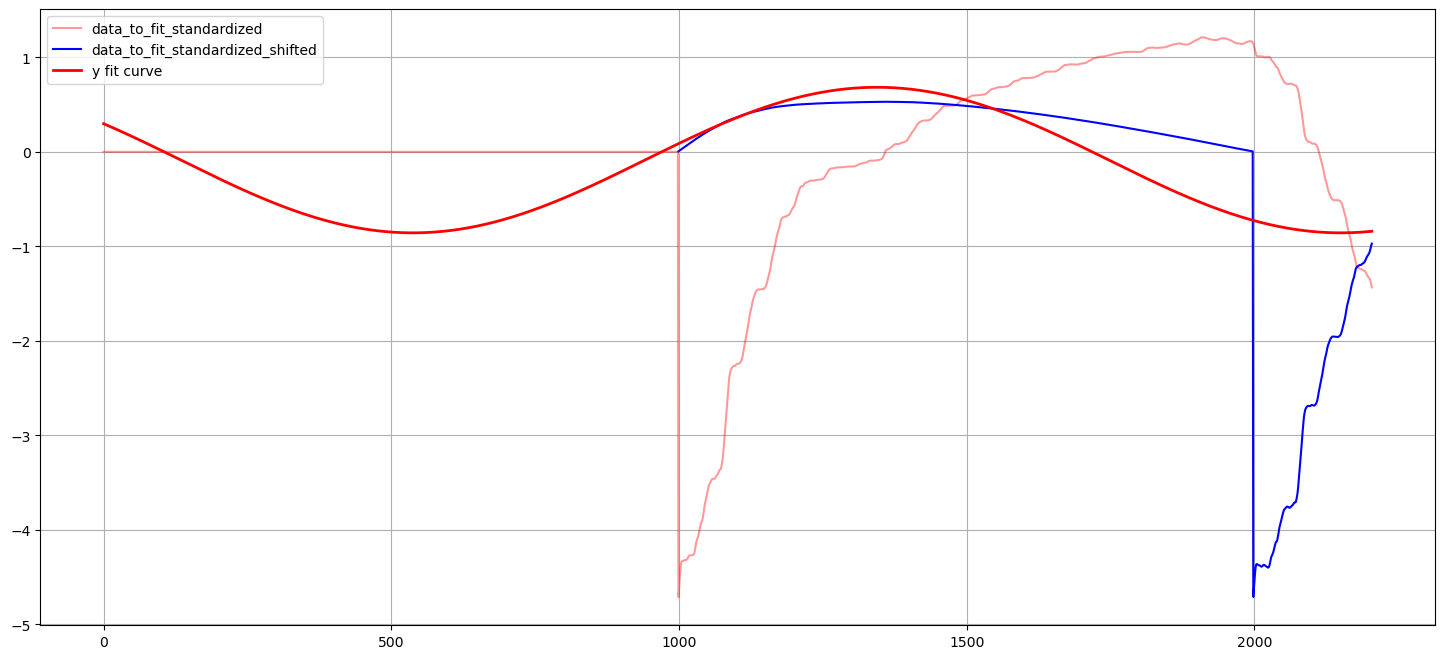

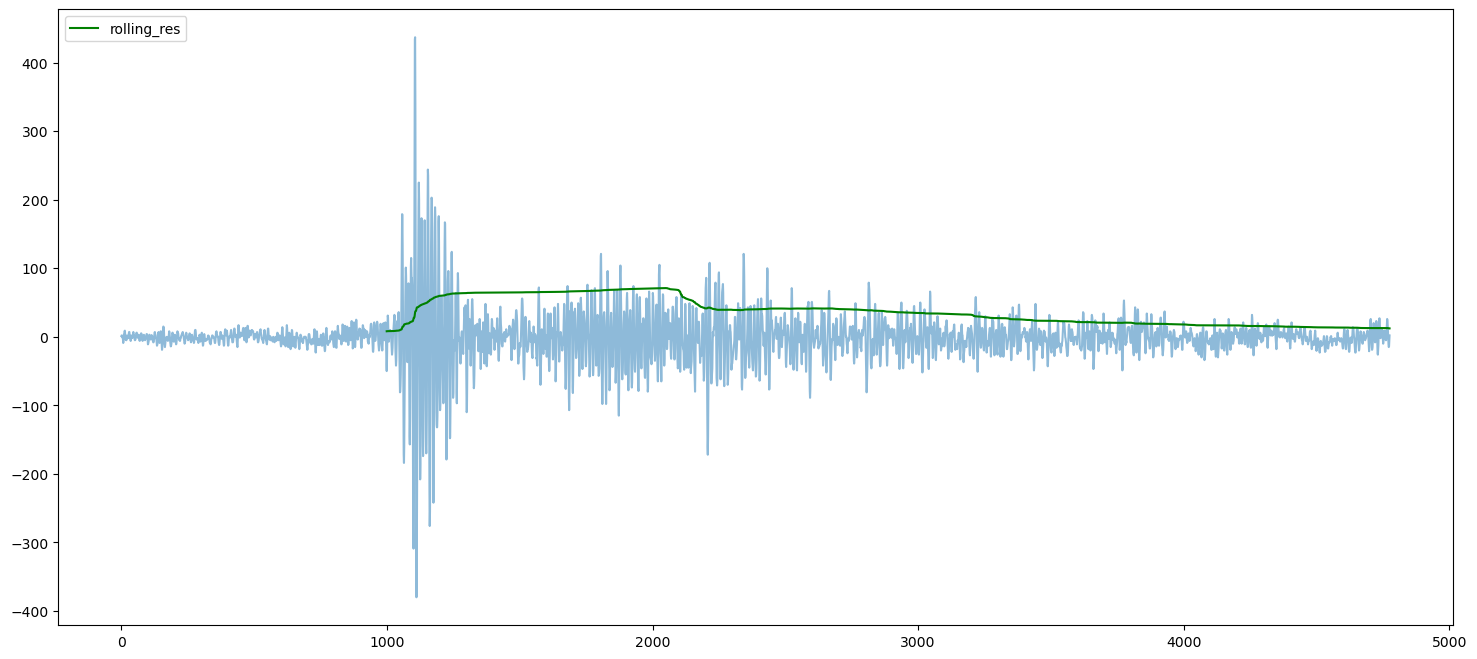

Amplitude=-0.6615390303383313, Angular freq.=0.0016053839190850031, phase=-1.0106458618448284, offset=0.11500657030018503, Max. Cov.=0.0009058575842367517


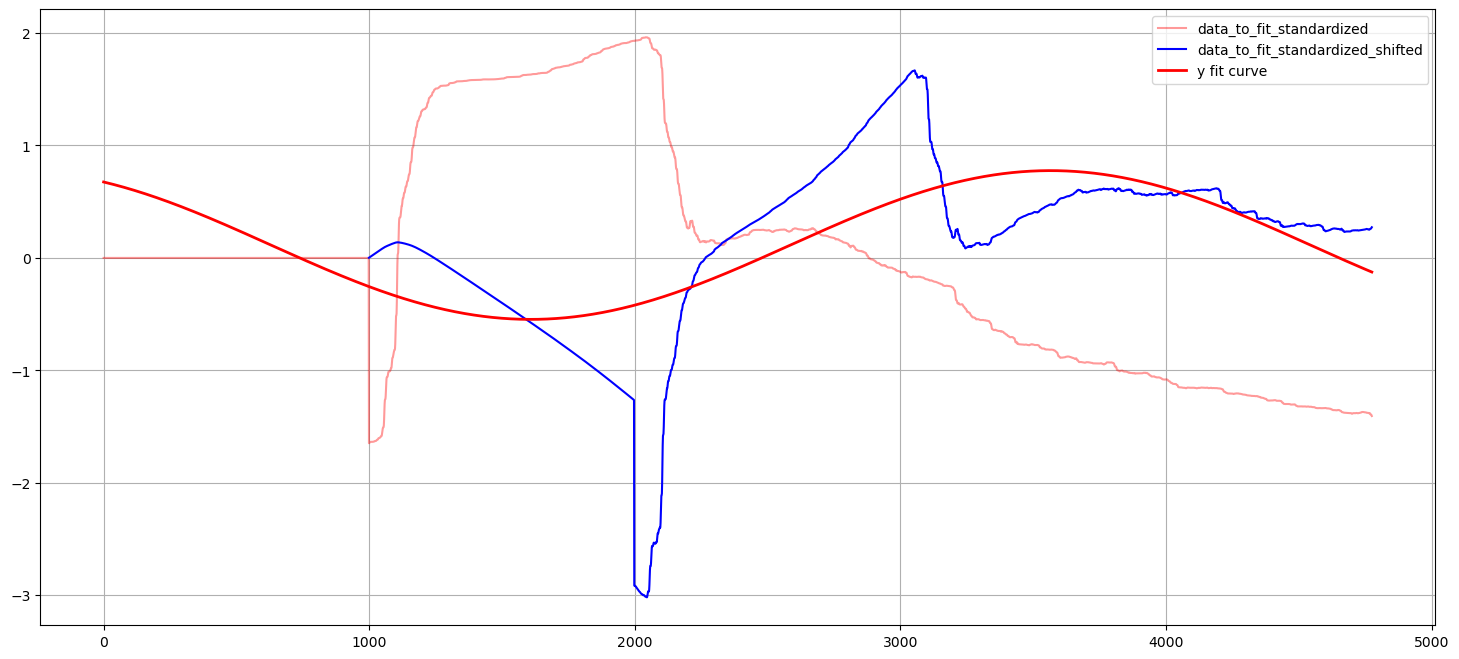

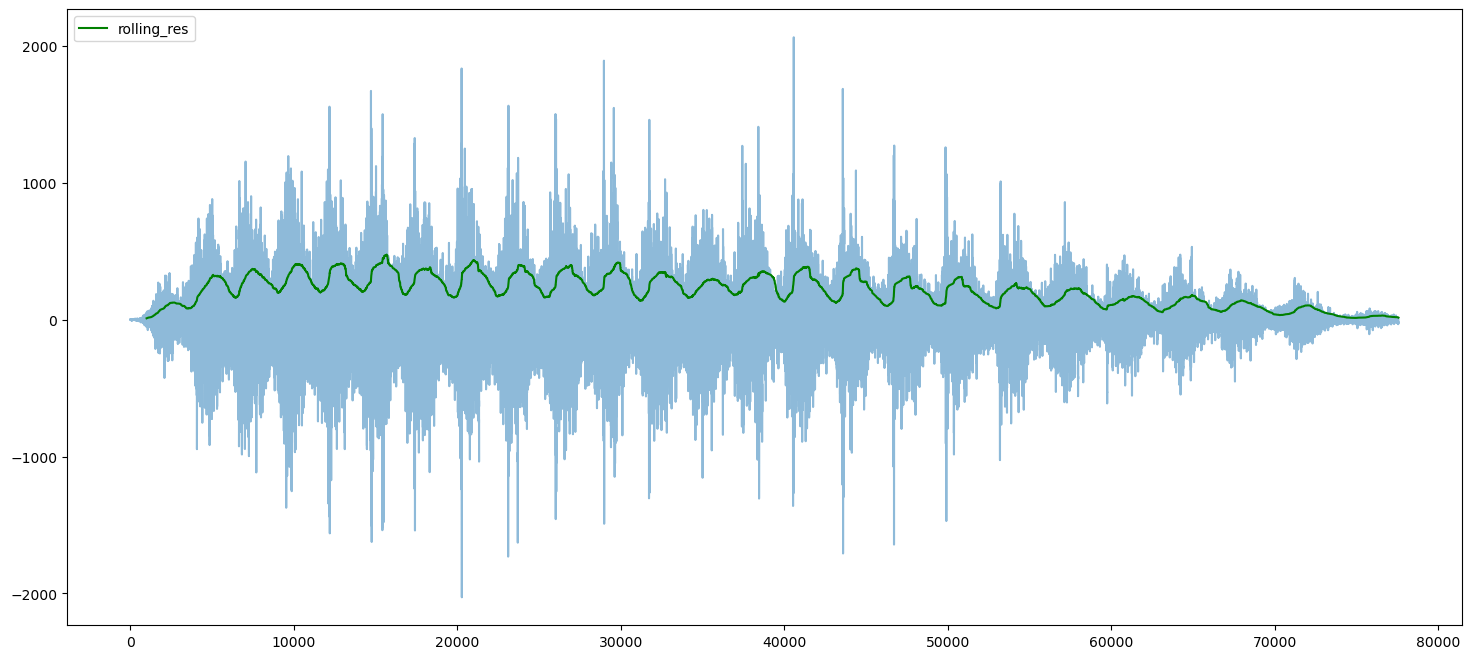

Amplitude=-0.35624002058923515, Angular freq.=0.0021808301902292247, phase=-0.8132546641490652, offset=0.012004344804931228, Max. Cov.=0.00020686988283227935


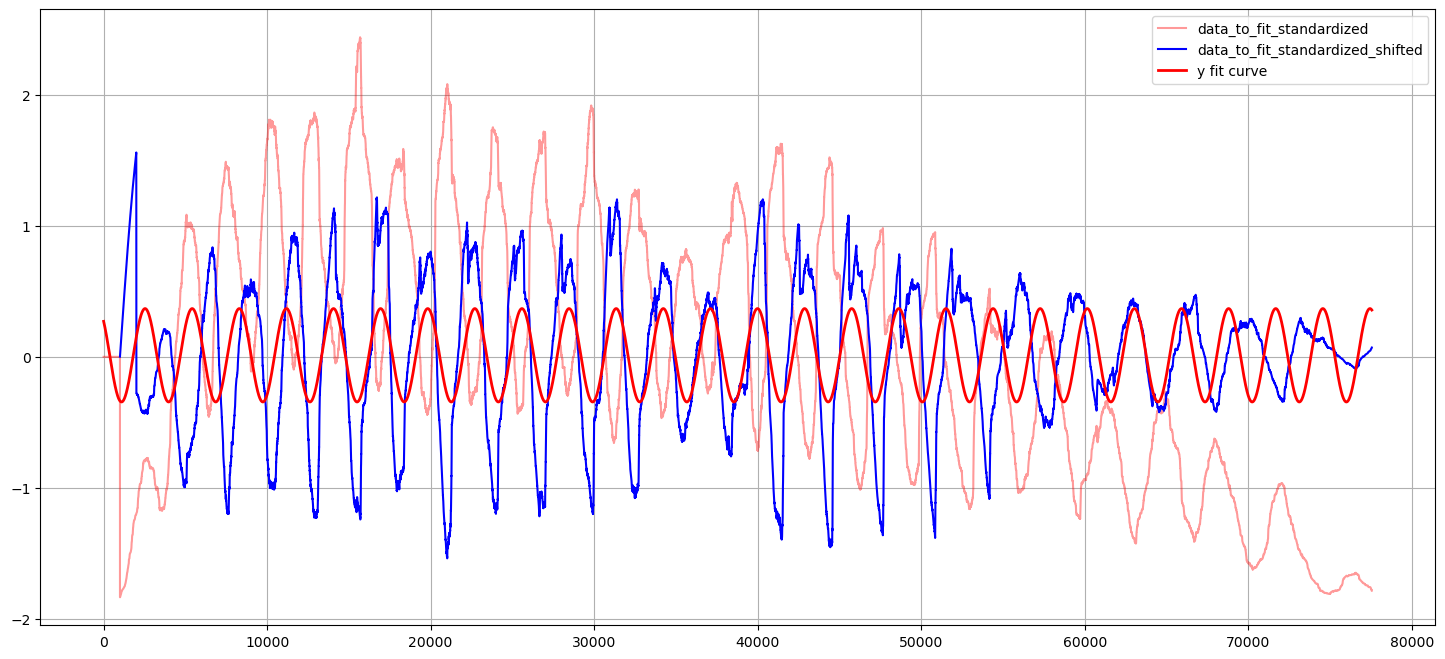

The bouncing frequency: 0.00034708990481901954	Period bounce count: 26	Period duration: 1.6157708333333334


In [212]:
all_result_dict = {}
period_index = 0
i=0
initial_window_size=INITIAL_WINDOW_SIZE
for period_start, period_end in signal_on_periods:
    try:
        one_result_dict = {}
        one_result_dict['start'] = period_start
        one_result_dict['end'] = period_end
        one_sample = samples[period_start:period_end]
        plt.figure(figsize=FIG_SIZE)
        if SHOW_FIGURES:
            plt.plot(one_sample, alpha=0.5)

        # if you want to listen to the segment, uncomment the lines below
        # 1000 here because it is in milliseconds
        # seg = sound[period_start/original_sample_rate*1000:period_end/original_sample_rate*1000]
        # play(seg)

        one_sample_series=pd.Series(one_sample)
        # calculate the standard deviation
        #periods with sound of ball hitting wall have high variance in values
        def func1(x):
            return np.std(x)
        rolling_res=one_sample_series.rolling(window=initial_window_size).apply(func1)
        if SHOW_FIGURES:
            plt.plot(rolling_res, color='green', alpha=1, label='rolling_res')
            plt.legend(loc="upper left")
            plt.show()

        # fit sine wave
        if SHOW_FIGURES:
            fig, ax = plt.subplots(figsize=FIG_SIZE)
        data_to_fit=rolling_res
        # filling na data
        data_to_fit=data_to_fit.fillna(np.mean(data_to_fit))
        # standardizing the data to make it easier for fitting signal to identify it
        dataMean = np.mean(data_to_fit)
        dataStd=np.std(data_to_fit)
        data_to_fit_standardized=(data_to_fit-dataMean)/dataStd
        if SHOW_FIGURES:
            ax.plot(data_to_fit_standardized, color='red',
                    alpha=0.4, label='data_to_fit_standardized')

        # shift the data to be around the x axis
        def func2(x):
            return x[0]-np.mean(x)
        data_to_fit_standardized_shifted = data_to_fit_standardized.rolling(window=initial_window_size).apply(func2, raw=True)
        if SHOW_FIGURES:
            ax.plot(data_to_fit_standardized_shifted, color='blue',
                    alpha=1, label='data_to_fit_standardized_shifted')
        x_vals = np.linspace(0, len(data_to_fit_standardized_shifted)-1,
                            num=len(data_to_fit_standardized_shifted))
        x_vals_test = np.linspace(0, len(data_to_fit_standardized_shifted)-1,
                                num=100 * len(data_to_fit_standardized))
        # replace na values
        ds_mean = data_to_fit_standardized_shifted.mean()
        data_to_fit_standardized_shifted.fillna(value=ds_mean, inplace=True)
        res = fit_sin(x_vals, data_to_fit_standardized_shifted)
        if SHOW_DEBUG_MESSAGES:
            print( "Amplitude=%(amp)s, Angular freq.=%(omega)s, phase=%(phase)s, offset=%(offset)s, Max. Cov.=%(maxcov)s" % res )
        if SHOW_FIGURES:
            plt.plot(x_vals_test, res["fitfunc"](x_vals_test), "r-", label="y fit curve", linewidth=2)
            ax.legend(loc='best')
            ax.grid(True, which='both')
            plt.show()

        # should I add this to the result:
        this_period_freq = res['omega']/(2*np.pi)
        this_period_bounce_count = int(
            this_period_freq*(period_end-period_start))
        if this_period_bounce_count > MINIMUM_BOUNCES_TO_ADD_TO_RESULTS:
            one_result_dict['period_index'] = period_index
            one_result_dict['the_freq'] = this_period_freq
            one_result_dict['bounce_count'] = int(
                one_result_dict['the_freq']*(period_end-period_start))
            one_result_dict['period_duration'] = (
                period_end-period_start)/original_sample_rate
            print('The bouncing frequency:', one_result_dict['the_freq'], end='\t')
            print('Period bounce count:', one_result_dict['bounce_count'], end='\t')
            print('Period duration:', one_result_dict['period_duration'])
            all_result_dict[period_index] = one_result_dict.copy()
            period_index += 1

        # i+=1
        # if i==2:
        #     break
    except Exception as error:
        print("An error has occured: ", error)

Export to Excel file

In [215]:
all_df=pd.DataFrame()
for period_index, period_details in all_result_dict.items():
    if all_df.size==0:
        all_df = pd.DataFrame(data=period_details, index=[0])
    else:
        one_df=pd.DataFrame(data=period_details, index=[0])
        all_df=pd.concat([all_df,one_df])

all_df.to_excel('./'+FILE_NAME+'Ball_Bounces.xlsx')


#### Appendix and helper functions

One Sample audio file

In [ ]:
one_sample=samples[100000:180000]
short_sound = AudioSegment(one_sample.tobytes(), frame_rate=sound.frame_rate,sample_width=sound.sample_width,channels=1)
file_handle = short_sound.export("short_sound_output.wav", format="wav")
plt.figure(figsize=FIG_SIZE)
plt.plot(one_sample)

Slow down file to count bounces and update model

In [ ]:
def speed_change(sound, speed=1.0):
    # Manually override the frame_rate. This tells the computer how many
    # samples to play per second
    sound_with_altered_frame_rate = sound._spawn(sound.raw_data, overrides={
        "frame_rate": int(sound.frame_rate * speed)
    })

    # convert the sound with altered frame rate to a standard frame rate
    # so that regular playback programs will work right. They often only
    # know how to play audio at standard frame rate (like 44.1k)
    return sound_with_altered_frame_rate.set_frame_rate(sound.frame_rate)

In [ ]:
slow_sound = speed_change(sound, 0.1)
file_handle = slow_sound.export(FILE_NAME_ONLY+"_SLOWED_DOWN.wav", format="wav")